# Example U-Net organ detector

## Imports + model initialization

In [1]:
import os
import torch
import importlib
import numpy as np
import pandas as pd
import tensorflow as tf

from tqdm import tqdm
from sklearn.utils import shuffle as sklearn_shuffle

from loggers import set_level
from utils.med_utils import TOTALSEGMENTATOR_LABELS
from utils import plot, plot_multiple, set_display_options, show_memory, is_equal
from datasets import get_dataset, prepare_dataset, test_dataset_time, train_test_split
from models.detection import med_unet_segmentator
from models import get_pretrained
from utils.med_utils import *

tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[:1], 'GPU')

set_display_options()

input_size = (None, None, 1)
model_name = 'seg_unet_orig_dce_v3'

print("Tensorflow version : {}".format(tf.__version__))
#print('# GPU(s) : {}'.format(len(tf.config.list_logical_devices('GPU'))))

2023-06-20 08:24:54.832502: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 08:24:55.885346: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-20 08:24:56.221095: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. E

Tensorflow version : 2.10.0


## Model creation

In [2]:
tf.config.set_visible_devices([], 'GPU')

importlib.reload(med_unet_segmentator)

if 'orig' not in model_name:
    ds     = get_dataset('total_segmentator')
    labels = list(sorted(ds.loc[0, 'label']))
else:
    labels = TOTALSEGMENTATOR_LABELS

if labels[0] is not None: labels = [None] + labels

if 'highres' in model_name:
    voxel_dims = (0.5, 0.5, 1.5)
elif 'lowres' in model_name:
    voxel_dims = (3., 3., 3.)
else:
    voxel_dims = (1.5, 1.5, 1.5)

config = {
    'input_size' : input_size,
    'voxel_dims' : voxel_dims,
    'n_frames'   : -1,
    'pad_value'  : 0.,
    'labels'     : labels,
    'image_normalization' : 'mean',
    
    'norm_type'  : 'layer' if 'ln' in model_name else 'instance'
}

if 'scratch' in model_name:
    config.update({
        # Architecture config
        'n_stages'   : 4,
        'n_conv_per_stage'    : 1,
        'up_n_conv_per_stage' : lambda i: min(i, 1),
        'filters'     : list(np.array([16, 32, 64, 128])),
        'bnorm'       : 'never',
        'activation'  : 'leaky',
        'drop_rate'   : lambda i: 0. if i == 0 else 0.25,

        'n_middle_stages' : 2,
        'n_middle_conv'   : 2,
        'middle_filters'  : 64,
        'middle_bnorm'    : 'never',

        'concat_mode'     : lambda i: 'concat' if i > 0 else None,
    })
else:
    config['pretrained_name'] = 'totalsegmentator'

model = med_unet_segmentator.MedUNetSegmentator(
    nom = model_name, ** config
)

print(model)

Initializing model with kwargs : {'model': {'architecture_name': 'totalsegmentator', 'input_shape': (None, None, None, 1), 'output_dim': 105, 'final_activation': None, 'norm_type': 'instance'}}


2023-06-16 10:08:04.539952: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.




Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

nnUNet_raw_data_base is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read nnunet/paths.md for information on how to set this up properly.
nnUNet_preprocessed is not defined and nnU-Net can not be used for preprocessing or training. If this is not intended, please read nnunet/pathy.md for information on how to set this up.
RESULTS_FOLDER is not defined and nnU-Net cannot be used for training or inference. If this is not intended behavior, please read nnunet/

/etinfo/users2/qlanglois/phd_segmentation/models/weights_converter.py:102: UserWarning: Unable to determine the root based on candidates : {'conv_blocks_localization': 40, 'conv_blocks_context': 48, 'tu': 5, 'seg_outputs': 5}
  warnings.warn('Unable to determine the root based on candidates : {}'.format(parts))
/etinfo/users2/qlanglois/phd_segmentation/models/weights_converter.py:102: UserWarning: Unable to determine the root based on candidates : {'conv_blocks_context': 48, 'tu': 5, 'conv_blocks_localization': 40, 'seg_outputs': 1}
  warnings.warn('Unable to determine the root based on candidates : {}'.format(parts))


Weights transfered successfully !
Initializing submodel : `model` !
Submodel model saved in pretrained_models/seg_unet_orig_dce_v3/saving/model.json !
Model seg_unet_orig_dce_v3 initialized successfully !

========== seg_unet_orig_dce_v3 ==========
Sub model model
- Inputs 	: (None, None, None, None, 1)
- Outputs 	: (None, None, None, None, 105)
- Number of layers 	: 122
- Number of parameters 	: 30.480 Millions
- Model not compiled

Transfer-learning from : totalsegmentator
Already trained on 0 epochs (0 steps)

- Image size : (None, None, 1)
- Normalization style : mean
- Labels (n = 105) : [None, 'spleen', 'kidney_right', 'kidney_left', 'gallbladder', 'liver', 'stomach', 'aorta', 'inferior_vena_cava', 'portal_vein_and_splenic_vein', 'pancreas', 'adrenal_gland_right', 'adrenal_gland_left', 'lung_upper_lobe_left', 'lung_lower_lobe_left', 'lung_upper_lobe_right', 'lung_middle_lobe_right', 'lung_lower_lobe_right', 'vertebrae_L5', 'vertebrae_L4', 'vertebrae_L3', 'vertebrae_L2', 'vertebra

In [3]:
model.summary()


========== Summary of model ==========

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, None, None,  0           []                               
                                 None, 1)]                                                        
                                                                                                  
 zero_padding3d (ZeroPadding3D)  (None, None, None,   0          ['input_image[0][0]']            
                                None, 1)                                                          
                                                                                                  
 conv_blocks_context/0/blocks/0  (None, None, None,   896        ['zero_padding3d[0][0]']         
 /conv (Conv3D)                 None, 32)            

## Model instanciation + dataset loading

In [2]:
model = get_pretrained(model_name)

if 'scratch' in model_name:
    lr = {'name' : 'DivideByStep', 'maxval' : 1e-2,'minval' : 1e-4}
else:
    lr = {'name' : 'DivideByStep', 'maxval' : 1e-3,'minval' : 1e-4}

loss = 'DiceLoss'
if 'dbce' in model_name:  loss = 'DiceWithBCELoss'
elif 'dce' in model_name: loss = 'DiceWithCELoss'
elif 'bce' in model_name: loss = 'BinaryCrossentropyLoss'

loss_config = {'threshold' : 0.001, 'loss_averaging' : 'micro', 'dice_weight' : 1., 'ce_weight' : 1.}

model.compile(
    loss = loss, optimizer = 'adam', optimizer_config = {'lr' : lr}, loss_config = loss_config
)

print(model)

2023-06-20 08:25:14.420813: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 08:25:28.100497: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14411 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:17:00.0, compute capability: 7.5


Model restoration...
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for

In [3]:
dataset_name = 'total_segmentator'
dataset = get_dataset(dataset_name, slice_step = 16, slice_size = 32, output_format = ('stensor', 'tensor', 'npz'))

keep_mask = dataset['segmentation'].apply(lambda f: not f.endswith('nii.gz'))
dataset   = dataset[keep_mask]

if isinstance(dataset, dict):
    train, valid = dataset['train'], dataset['valid']
else:
    train, valid = train_test_split(
        dataset, train_size = 0.9, shuffle = True, random_state = 10, split_by_unique = True, min_occurence = 0
    )
    train = sklearn_shuffle(train, random_state = model.epochs)

print('Dataset length ({} data skipped, {} ids) :\n  Train size : {} ({} ids)\n  Valid size : {} ({} ids)'.format(
    len(keep_mask) - np.sum(keep_mask.values), len(dataset['id'].unique()), 
    len(train), len(train['id'].unique()), len(valid), len(valid['id'].unique())
))
print('# ids in valid that are also in train : {}'.format(len([id_i for id_i in valid['id'].unique() if id_i in train['id'].values])))

Loading dataset total_segmentator...
Dataset length (53 data skipped, 1202 ids) :
  Train size : 17969 (1081 ids)
  Valid size : 2066 (121 ids)
# ids in valid that are also in train : 0


## Training + history analysis

In [ ]:
for epochs in [3]:
    batch_size = 1

    if 'highres' in model_name:
        max_size, max_frames = 512, 32
    elif 'lowres' in model_name:
        max_size, max_frames = 128, 128
    else:
        max_size, max_frames = 256 - 64, 32

    augment_prct = 0.2
    shuffle_size = 0 if epochs + model.epochs < 2 else batch_size * 8

    crop_mode    = ['random_center_80', 'random_center_80', 'random']
    skip_empty_frames   = True if model.epochs < 5 else False
    skip_empty_labels   = True #if model.epochs < 10 else False

    if 'test' in model_name:
        train = train.sample(10, random_state = 0)
        valid = valid.sample(10, random_state = 0)

    if 'scratch' not in model_name and model.epochs < 1 and 'orig' not in model_name and 'ln' not in model_name:
        for l in model.layers[:-2]: l.trainable = False
        epochs = 1
    else:
        for l in model.layers: l.trainable = True

    model.train(
        train, validation_data = valid, epochs = epochs, batch_size = batch_size,

        augment_prct = augment_prct, shuffle_size = shuffle_size,
        is_rectangular = True, cache = False,

        skip_empty_frames = skip_empty_frames, skip_empty_labels = skip_empty_labels,
        max_image_size = max_size, max_frames = max_frames, crop_mode = crop_mode, run_eagerly = False
    )

Training config :
HParams :
- augment_prct	: 0.2
- image_augmentation_methods	: ['noise']
- max_image_size	: 192
- crop_mode	: ['random_center_80', 'random_center_80', 'random']
- skip_empty_frames	: False
- skip_empty_labels	: True
- max_frames	: 32
- batch_size	: 1
- train_batch_size	: None
- valid_batch_size	: None
- test_batch_size	: 1
- shuffle_size	: 8
- epochs	: 3
- verbose	: 1
- train_times	: 1
- valid_times	: 1
- train_size	: None
- valid_size	: None
- test_size	: 4
- pred_step	: -1

Running on 1 GPU

Epoch 11 / 13
Epoch 11/3


2023-06-19 09:59:00.259952: W tensorflow/core/common_runtime/forward_type_inference.cc:332] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	while inferring type of node 'DiceLoss/cond_1/then/_657/DiceLoss/cond_1/cond_1/output/_1877'
2023-06-19 09:59:05.305055: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500


   2005/Unknown - 2321s 1s/step - loss: 0.7072 - dice_loss: 0.3535 - cross_entropy_loss: 0.3537

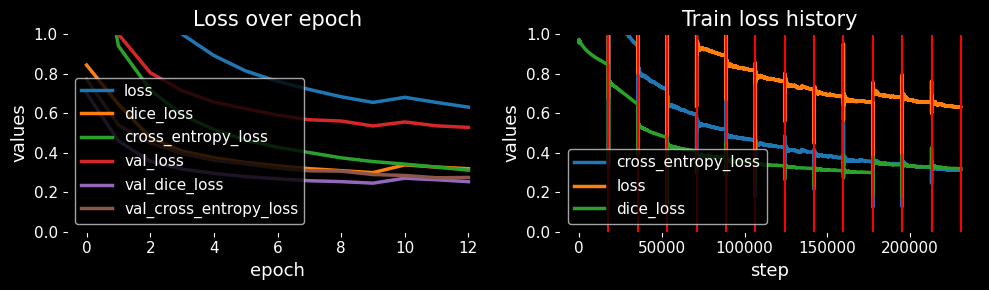

===== History =====
        loss  dice_loss  cross_entropy_loss  val_loss  val_dice_loss  val_cross_entropy_loss
0   2.674962   0.844237            1.830728  1.473991       0.701755                0.772238
1   1.586969   0.645809            0.941160  1.000714       0.459982                0.540732
2   1.195817   0.477184            0.718636  0.805526       0.356629                0.448897
3   1.000703   0.408821            0.591882  0.714369       0.317671                0.396696
4   0.892514   0.374740            0.517770  0.656897       0.295363                0.361534
5   0.814633   0.350709            0.463926  0.622539       0.279063                0.343476
6   0.761821   0.333819            0.428003  0.590718       0.268509                0.322209
7   0.720725   0.319646            0.401079  0.567053       0.258284                0.308769
8   0.683663   0.309312            0.374349  0.560879       0.253794                0.307084
9   0.654940   0.299447            0.355491  0.535

In [6]:
model.plot_history(ylim = (0, 1))
print(model.history)

In [7]:
pd.DataFrame(model.history.trainings_infos)

start                        end         time  interrupted  start_epoch  final_epoch
0 2023-06-13 11:38:14.189003 2023-06-14 05:54:08.839873  65754.65087        False           -1            2

In [8]:
from utils import time_to_string
time_to_string(65754)

'18h 15min 54sec'

In [ ]:
show_memory()

     47/Unknown - 117s 2s/step - loss: 7.9702 - dice_loss: 0.9654 - cross_entropy_loss: 7.0048

2023-06-13 11:30:39.536955: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at sparse_to_dense_op.cc:162 : INVALID_ARGUMENT: indices[5355] = [11,141,31,90] is out of bounds: need 0 <= index < [192,141,32,105]

     51/Unknown - 124s 2s/step - loss: 7.8238 - dice_loss: 0.9658 - cross_entropy_loss: 6.8581

## Evaluation

Row at index 13926


2023-06-20 08:25:55.775755: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
/etinfo/users2/qlanglois/phd_segmentation/models/detection/med_unet.py:204: RuntimeWarning: invalid value encountered in divide
  pred = pred / count


Image shape : (236, 236, 443, 1) - Mask shape : (236, 236, 443, 105) - Output shape : (236, 236, 443)
0.568155356321663
0.6170289353600857
# wrong labels : [  6   1   1   0  12 407 189 564]


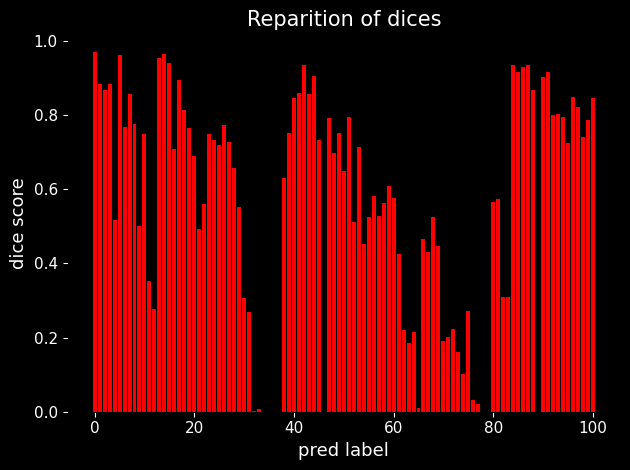

/tmp/ipykernel_1836234/1840194771.py:28: RuntimeWarning: invalid value encountered in divide
  plot_matrix(confusion / np.sum(confusion, axis = -1, keepdims = True), title = 'Confusion matrix', xlabel = 'pred', ylabel = 'target')


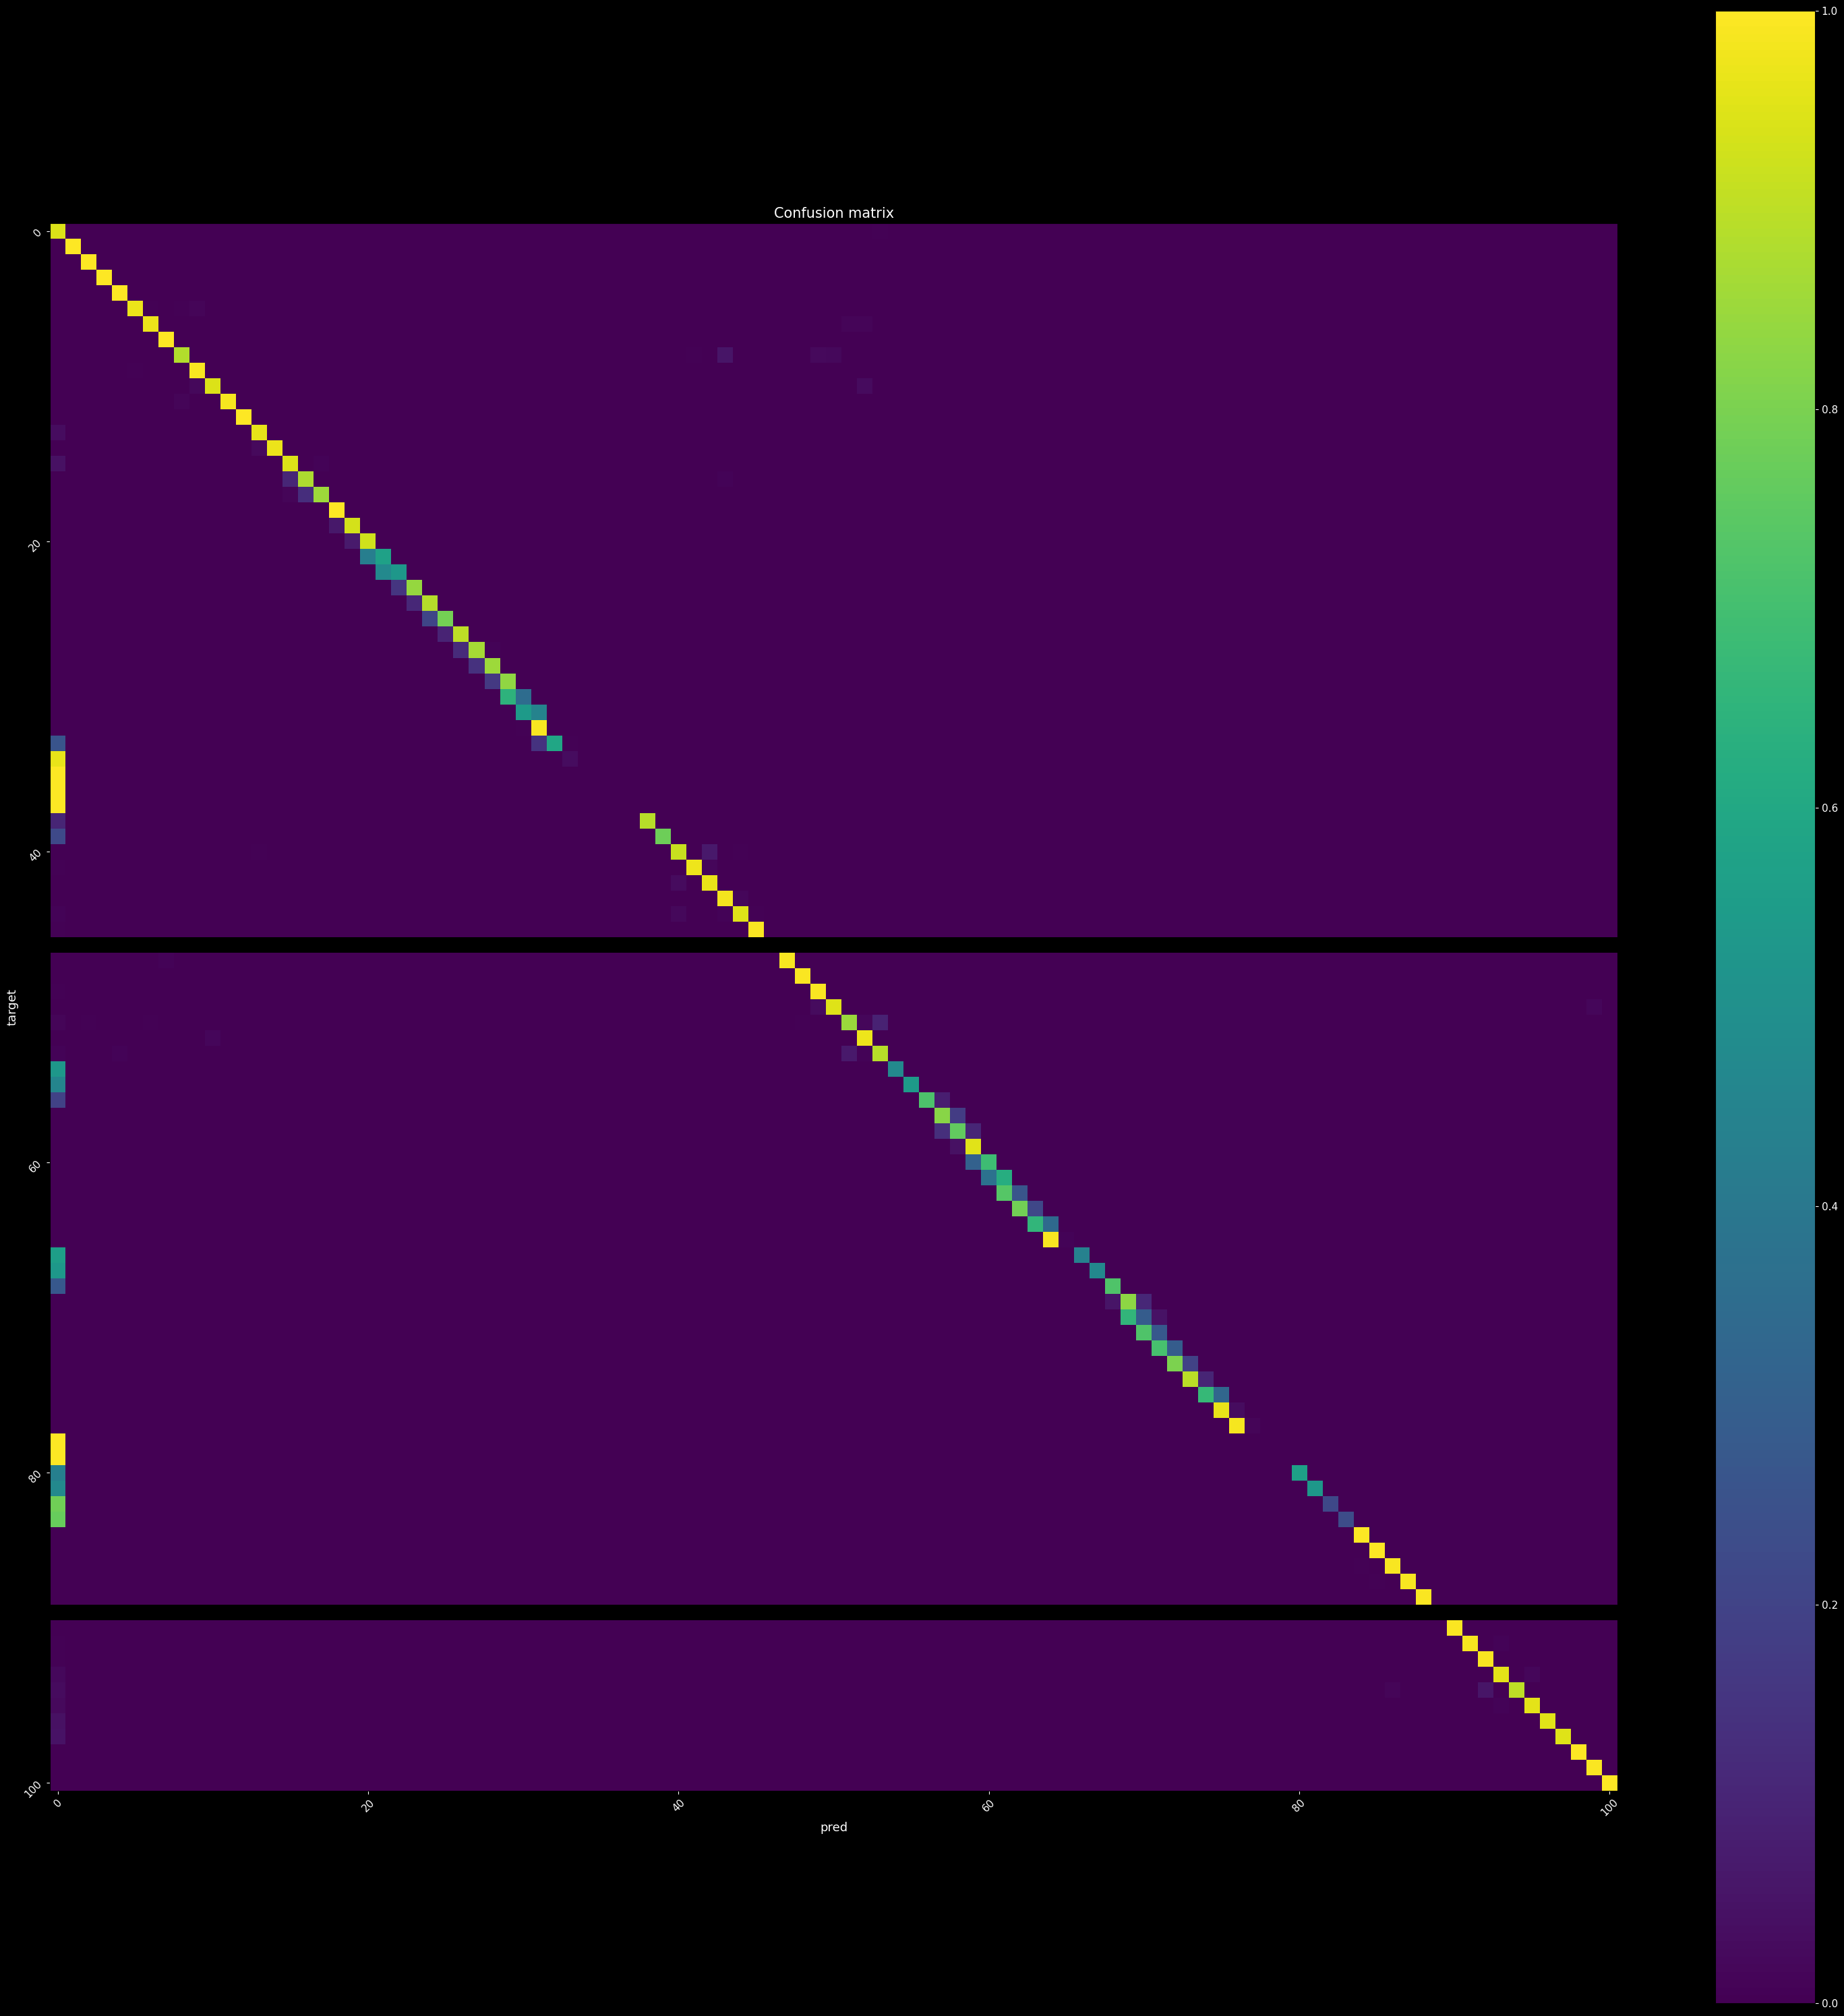

Row at index 4655


/etinfo/users2/qlanglois/phd_segmentation/models/detection/med_unet.py:204: RuntimeWarning: invalid value encountered in divide
  pred = pred / count


Image shape : (233, 233, 224, 1) - Mask shape : (233, 233, 224, 105) - Output shape : (233, 233, 224)
0.36669667043256254
0.673929015930115
# wrong labels : [   34 16422     4  6498     4     1    10  1163    73    98  1211   539
     1    23    67     0     1   599    11   207     2     2     2     3
     2    30   116    74   102   531     1]


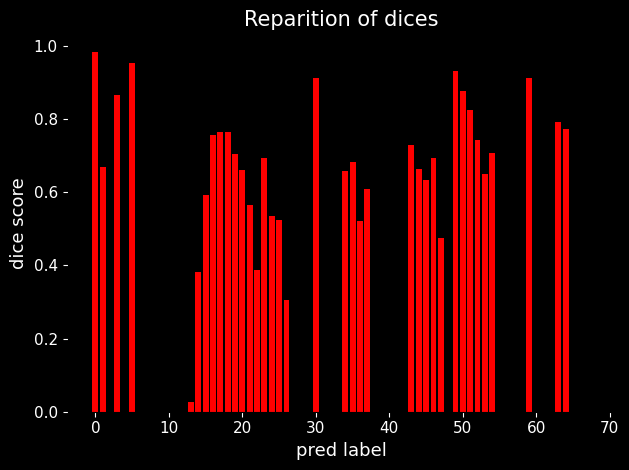

/tmp/ipykernel_1836234/1840194771.py:28: RuntimeWarning: invalid value encountered in divide
  plot_matrix(confusion / np.sum(confusion, axis = -1, keepdims = True), title = 'Confusion matrix', xlabel = 'pred', ylabel = 'target')


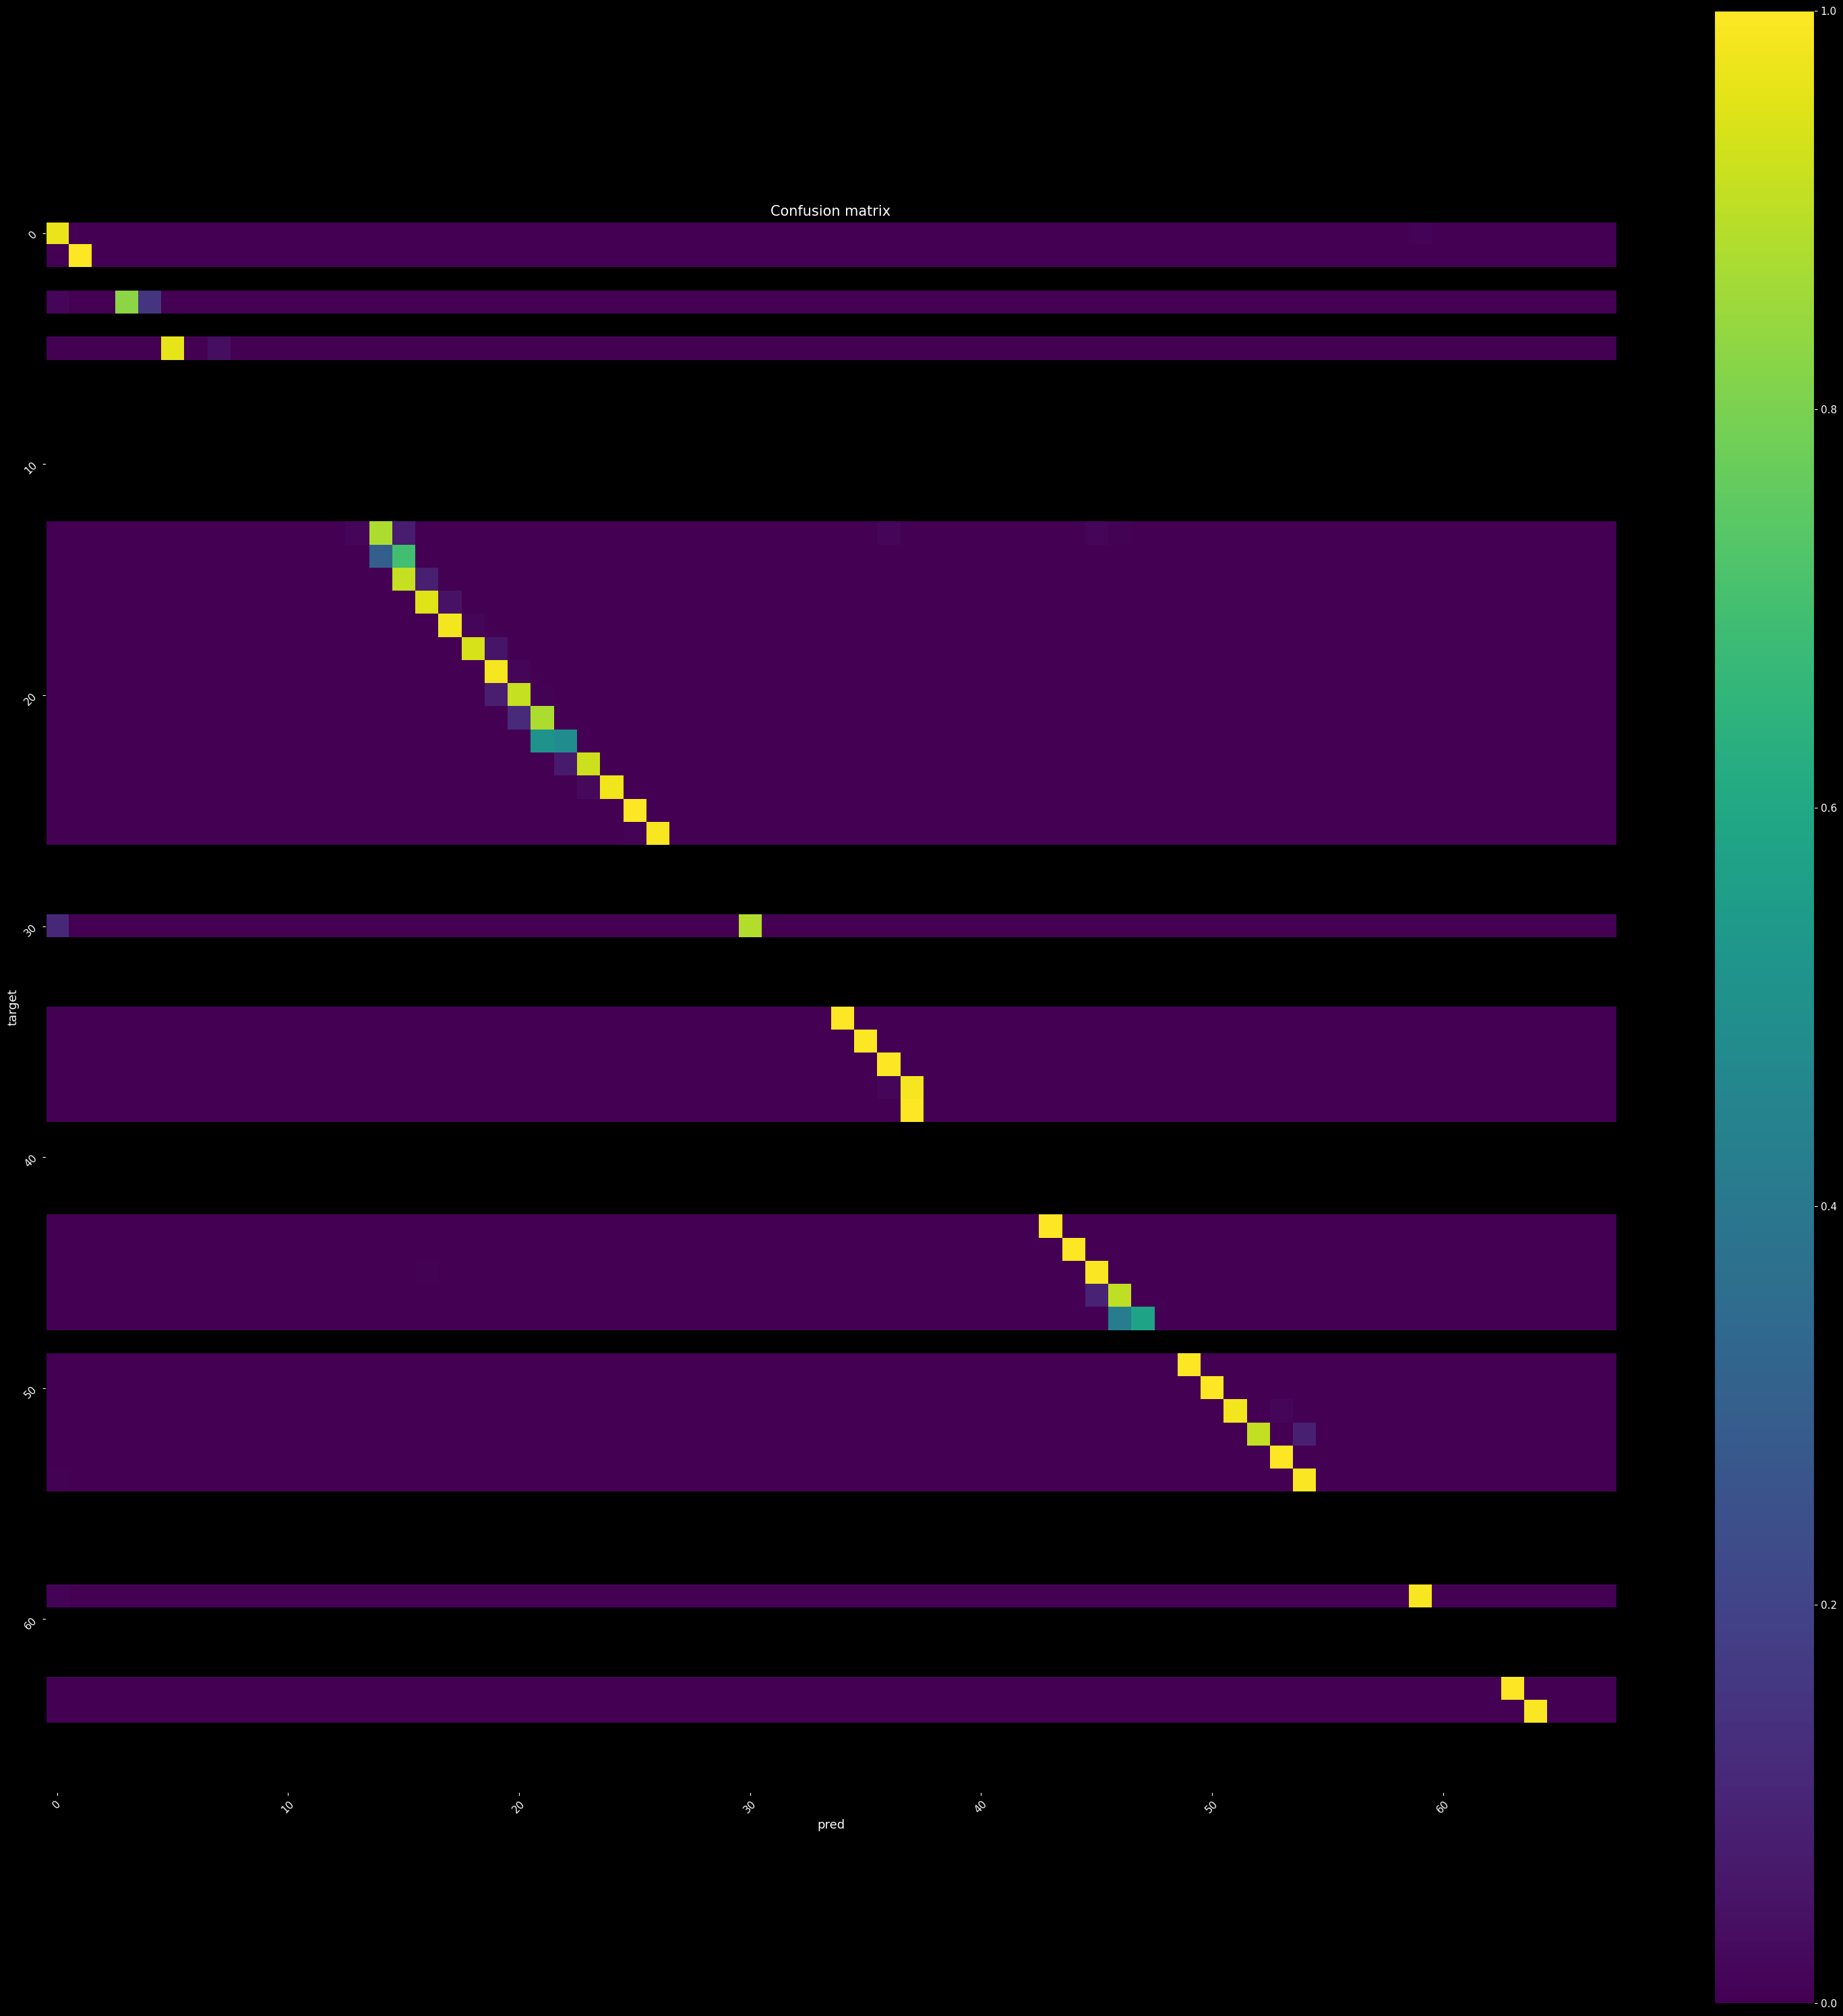

Row at index 17007


/etinfo/users2/qlanglois/phd_segmentation/models/detection/med_unet.py:204: RuntimeWarning: invalid value encountered in divide
  pred = pred / count


Image shape : (227, 227, 149, 1) - Mask shape : (227, 227, 149, 105) - Output shape : (227, 227, 149)
0.4392198595526406
0.5636654864258888
# wrong labels : [  78    3   32   16    5   88    6    5  240   11 2265    0   98  133
  850    1   14]


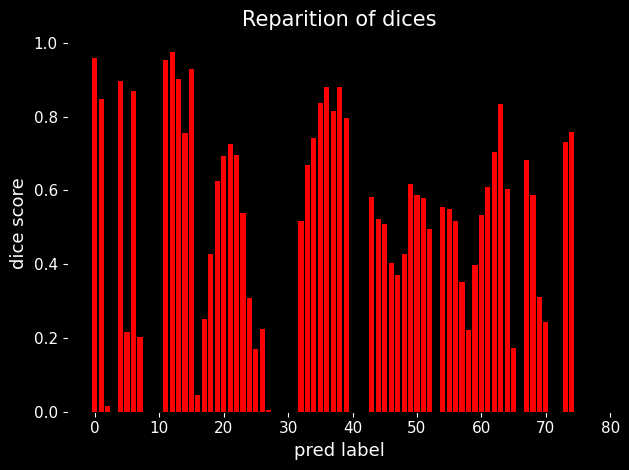

/tmp/ipykernel_1836234/1840194771.py:28: RuntimeWarning: invalid value encountered in divide
  plot_matrix(confusion / np.sum(confusion, axis = -1, keepdims = True), title = 'Confusion matrix', xlabel = 'pred', ylabel = 'target')


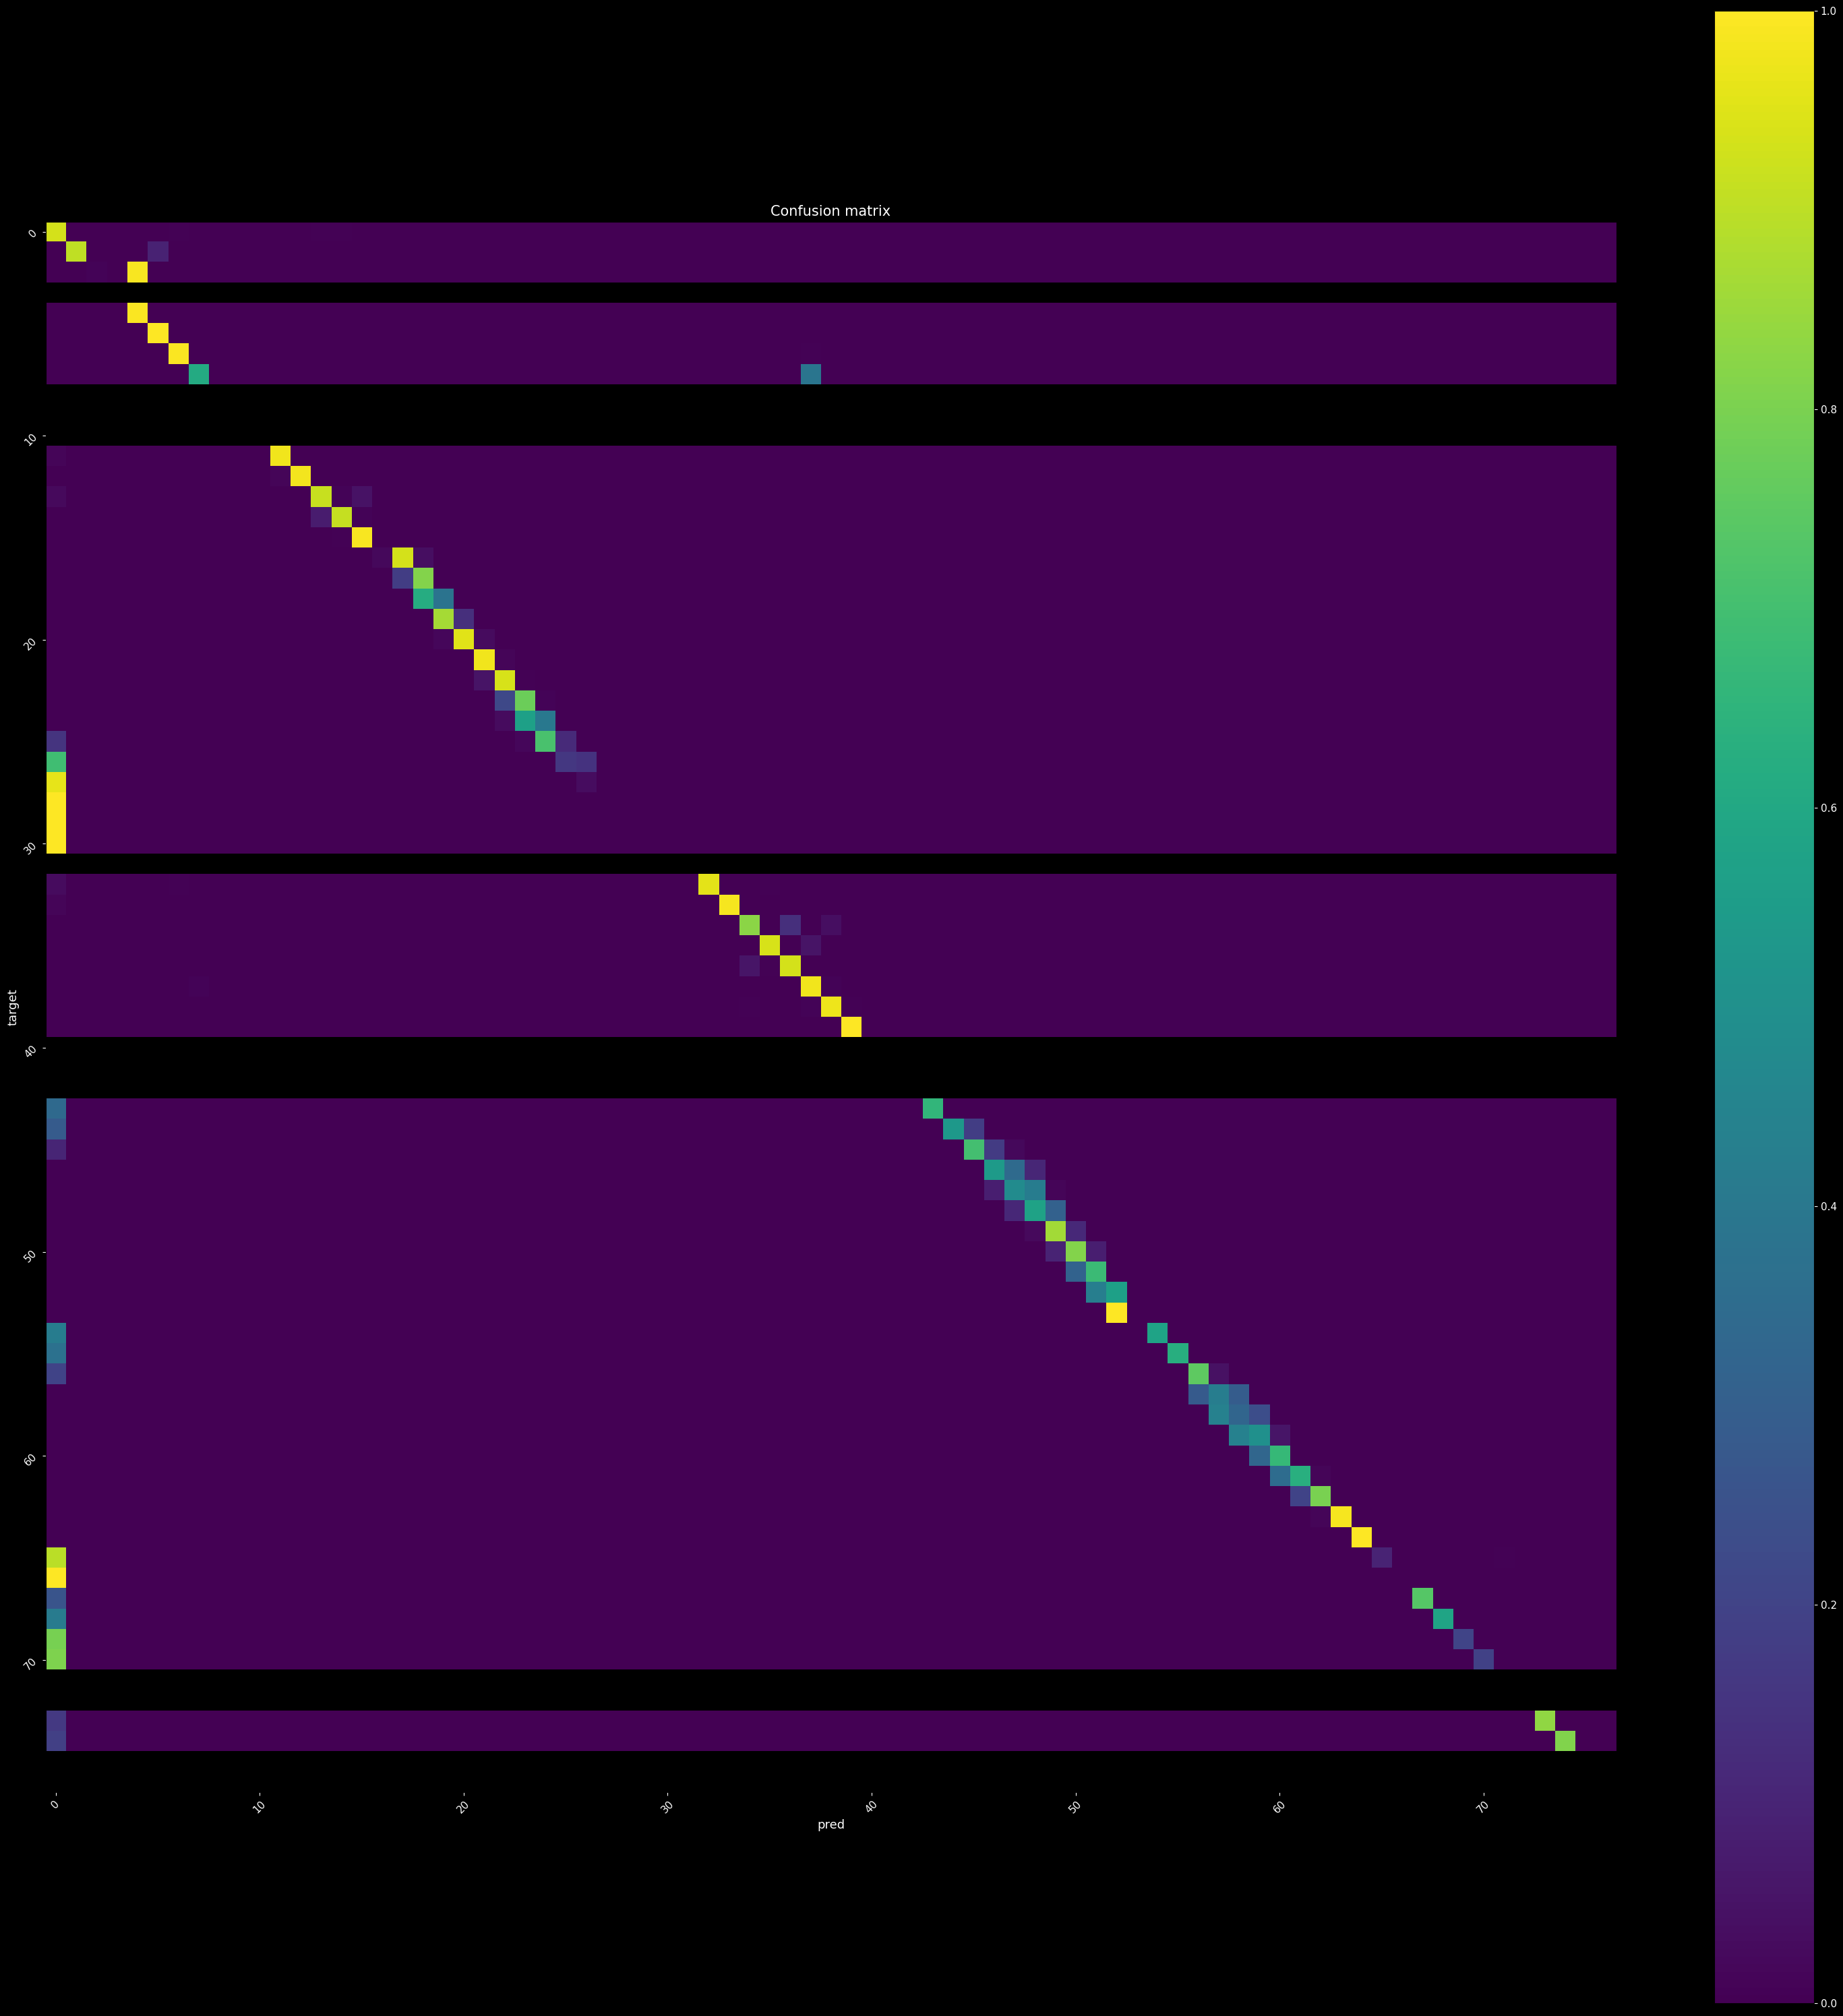

Row at index 1821
Image shape : (185, 185, 133, 1) - Mask shape : (185, 185, 133, 105) - Output shape : (185, 185, 133)
0.4546670701710468
0.7211960423402811
# wrong labels : [ 488    2 2875  545    4    1   37   15   24   59   27   19  281  861
    2    1    2]


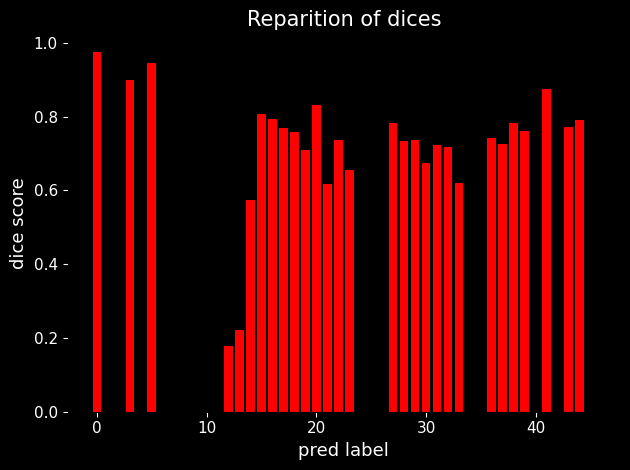

/tmp/ipykernel_1836234/1840194771.py:28: RuntimeWarning: invalid value encountered in divide
  plot_matrix(confusion / np.sum(confusion, axis = -1, keepdims = True), title = 'Confusion matrix', xlabel = 'pred', ylabel = 'target')


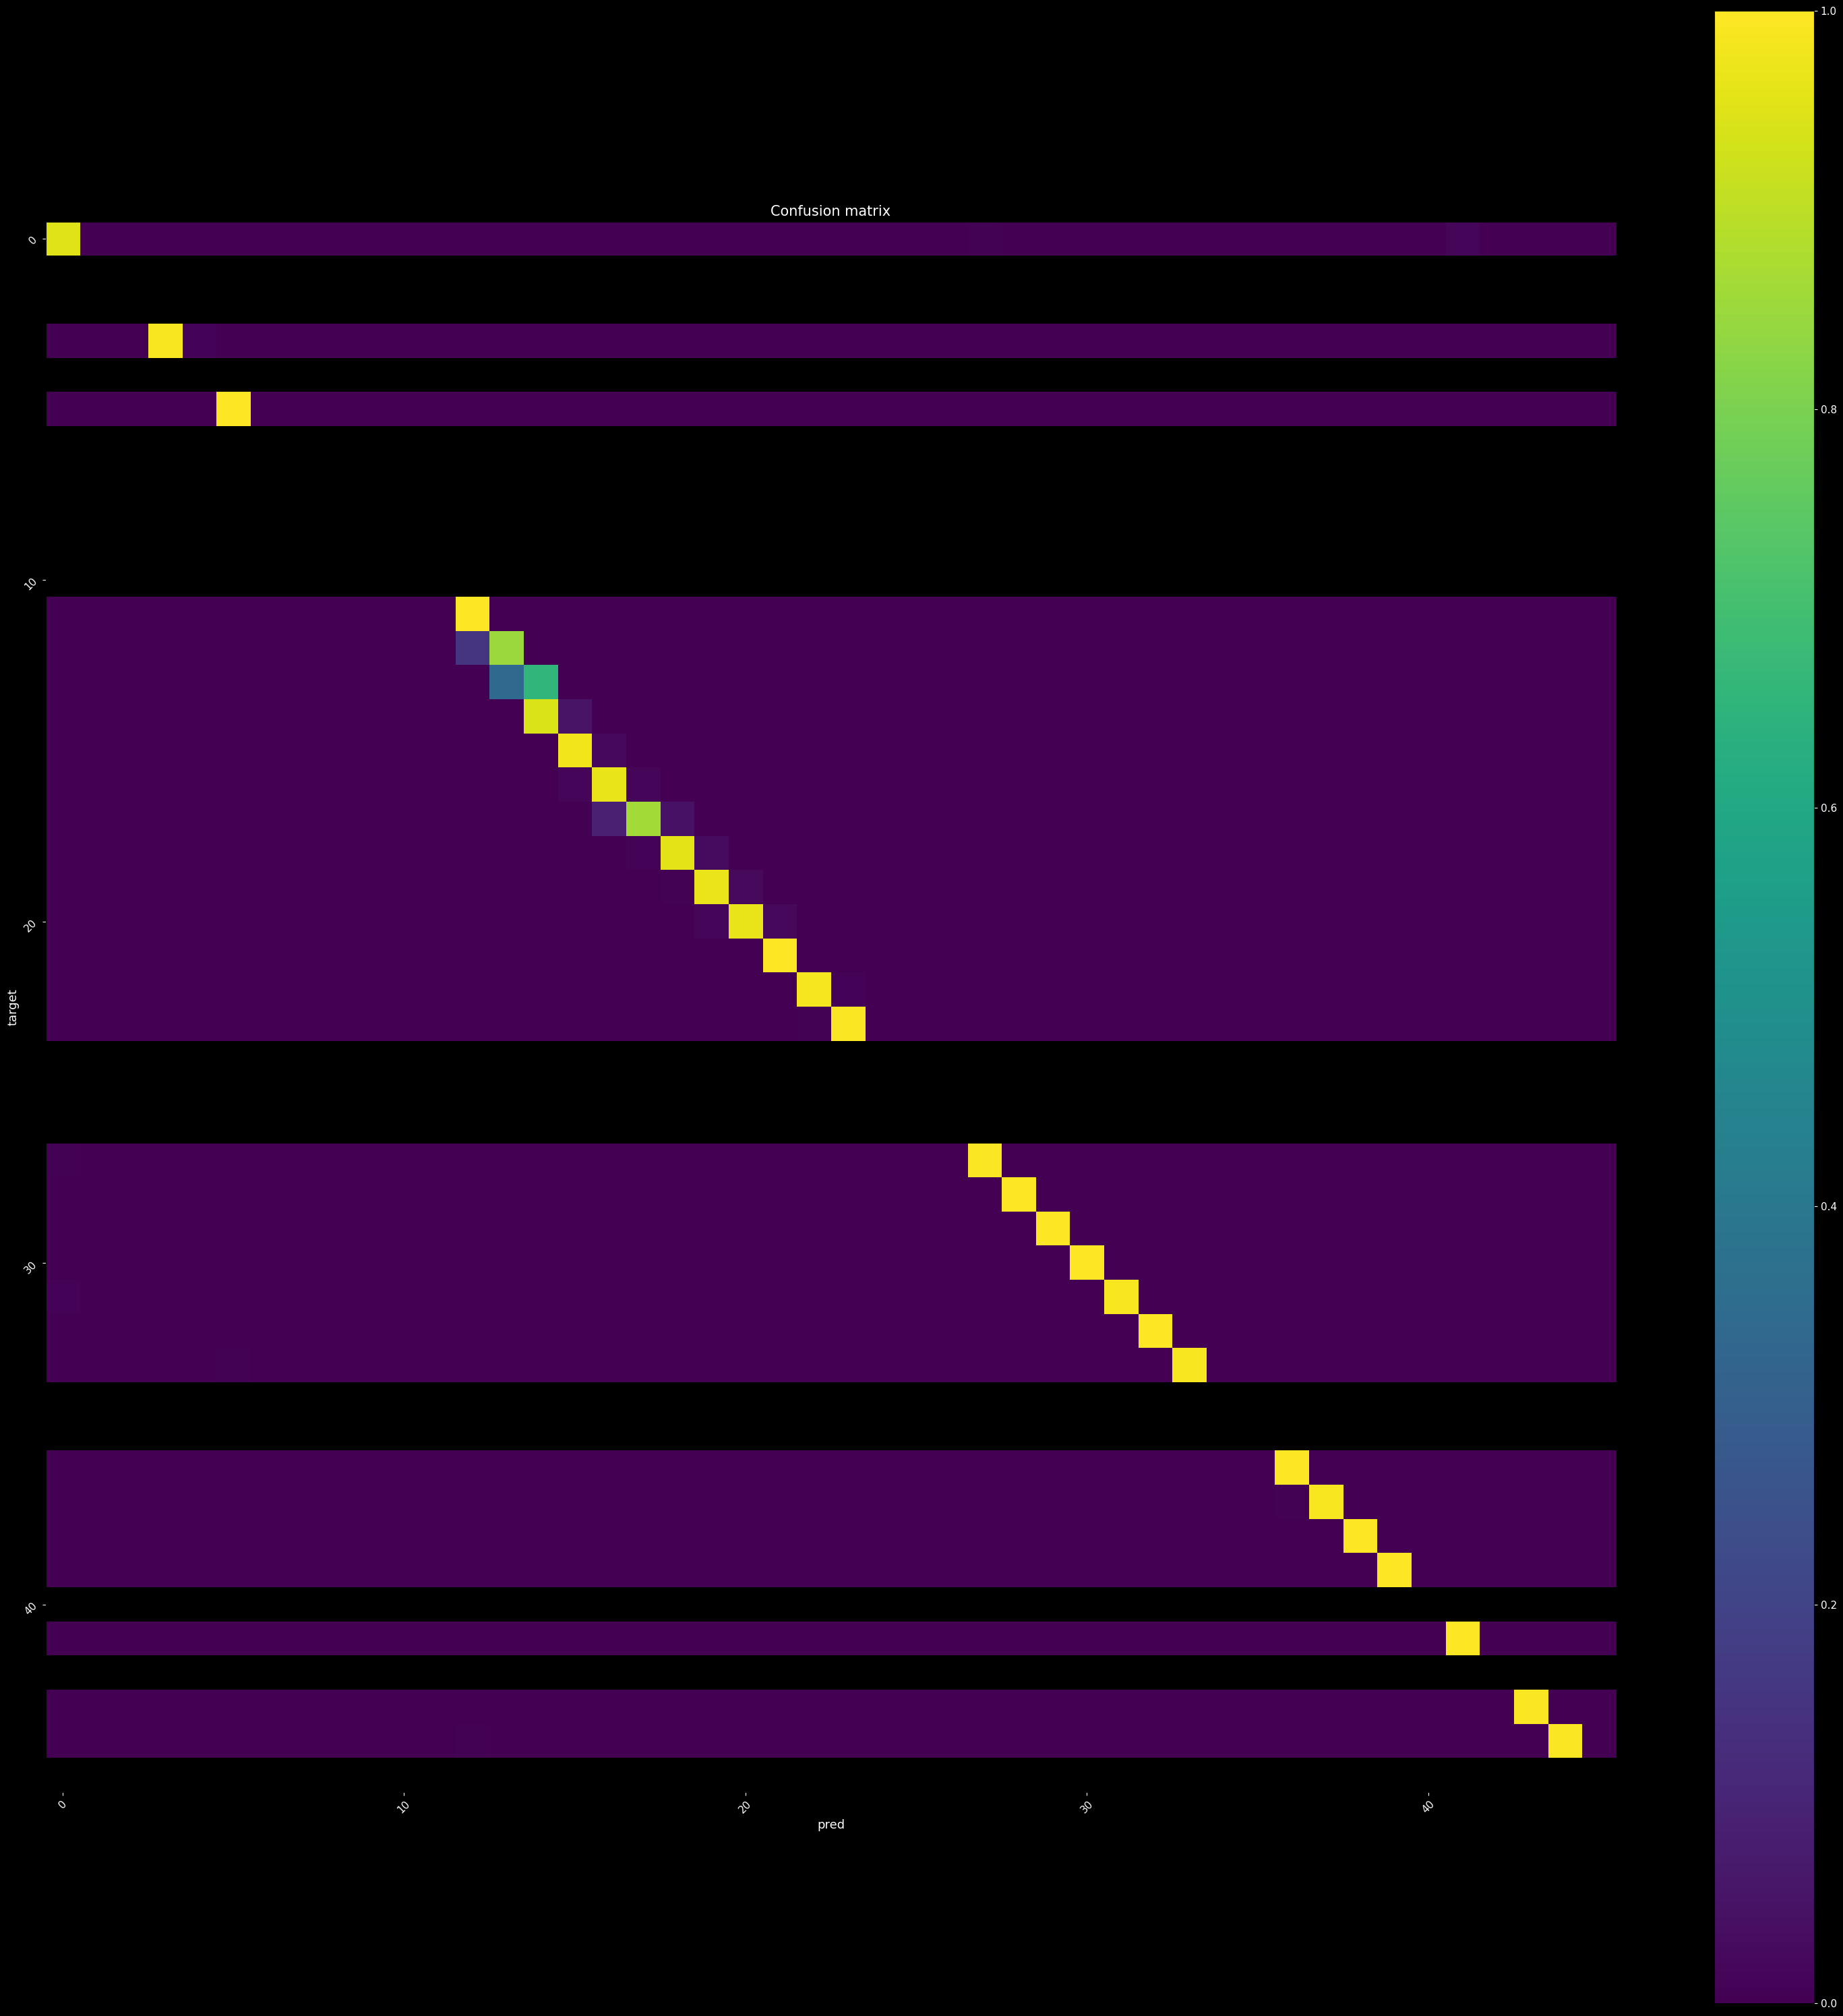

Row at index 17104


/etinfo/users2/qlanglois/phd_segmentation/models/detection/med_unet.py:204: RuntimeWarning: invalid value encountered in divide
  pred = pred / count


Image shape : (291, 291, 469, 1) - Mask shape : (291, 291, 469, 105) - Output shape : (291, 291, 469)
0.7035132243269079
0.7248318068822686
# wrong labels : [   52   350 23921]


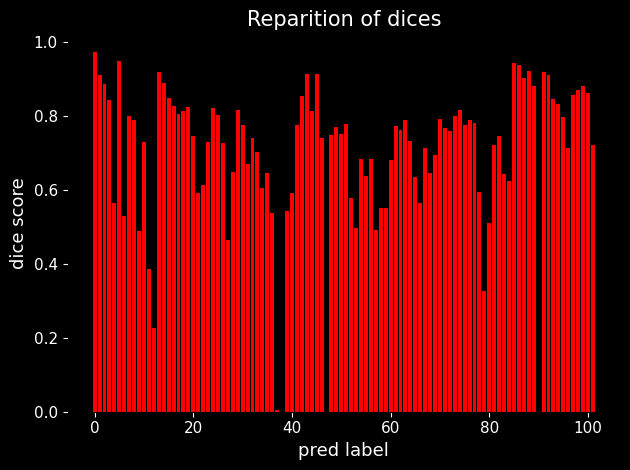

/tmp/ipykernel_1836234/1840194771.py:28: RuntimeWarning: invalid value encountered in divide
  plot_matrix(confusion / np.sum(confusion, axis = -1, keepdims = True), title = 'Confusion matrix', xlabel = 'pred', ylabel = 'target')


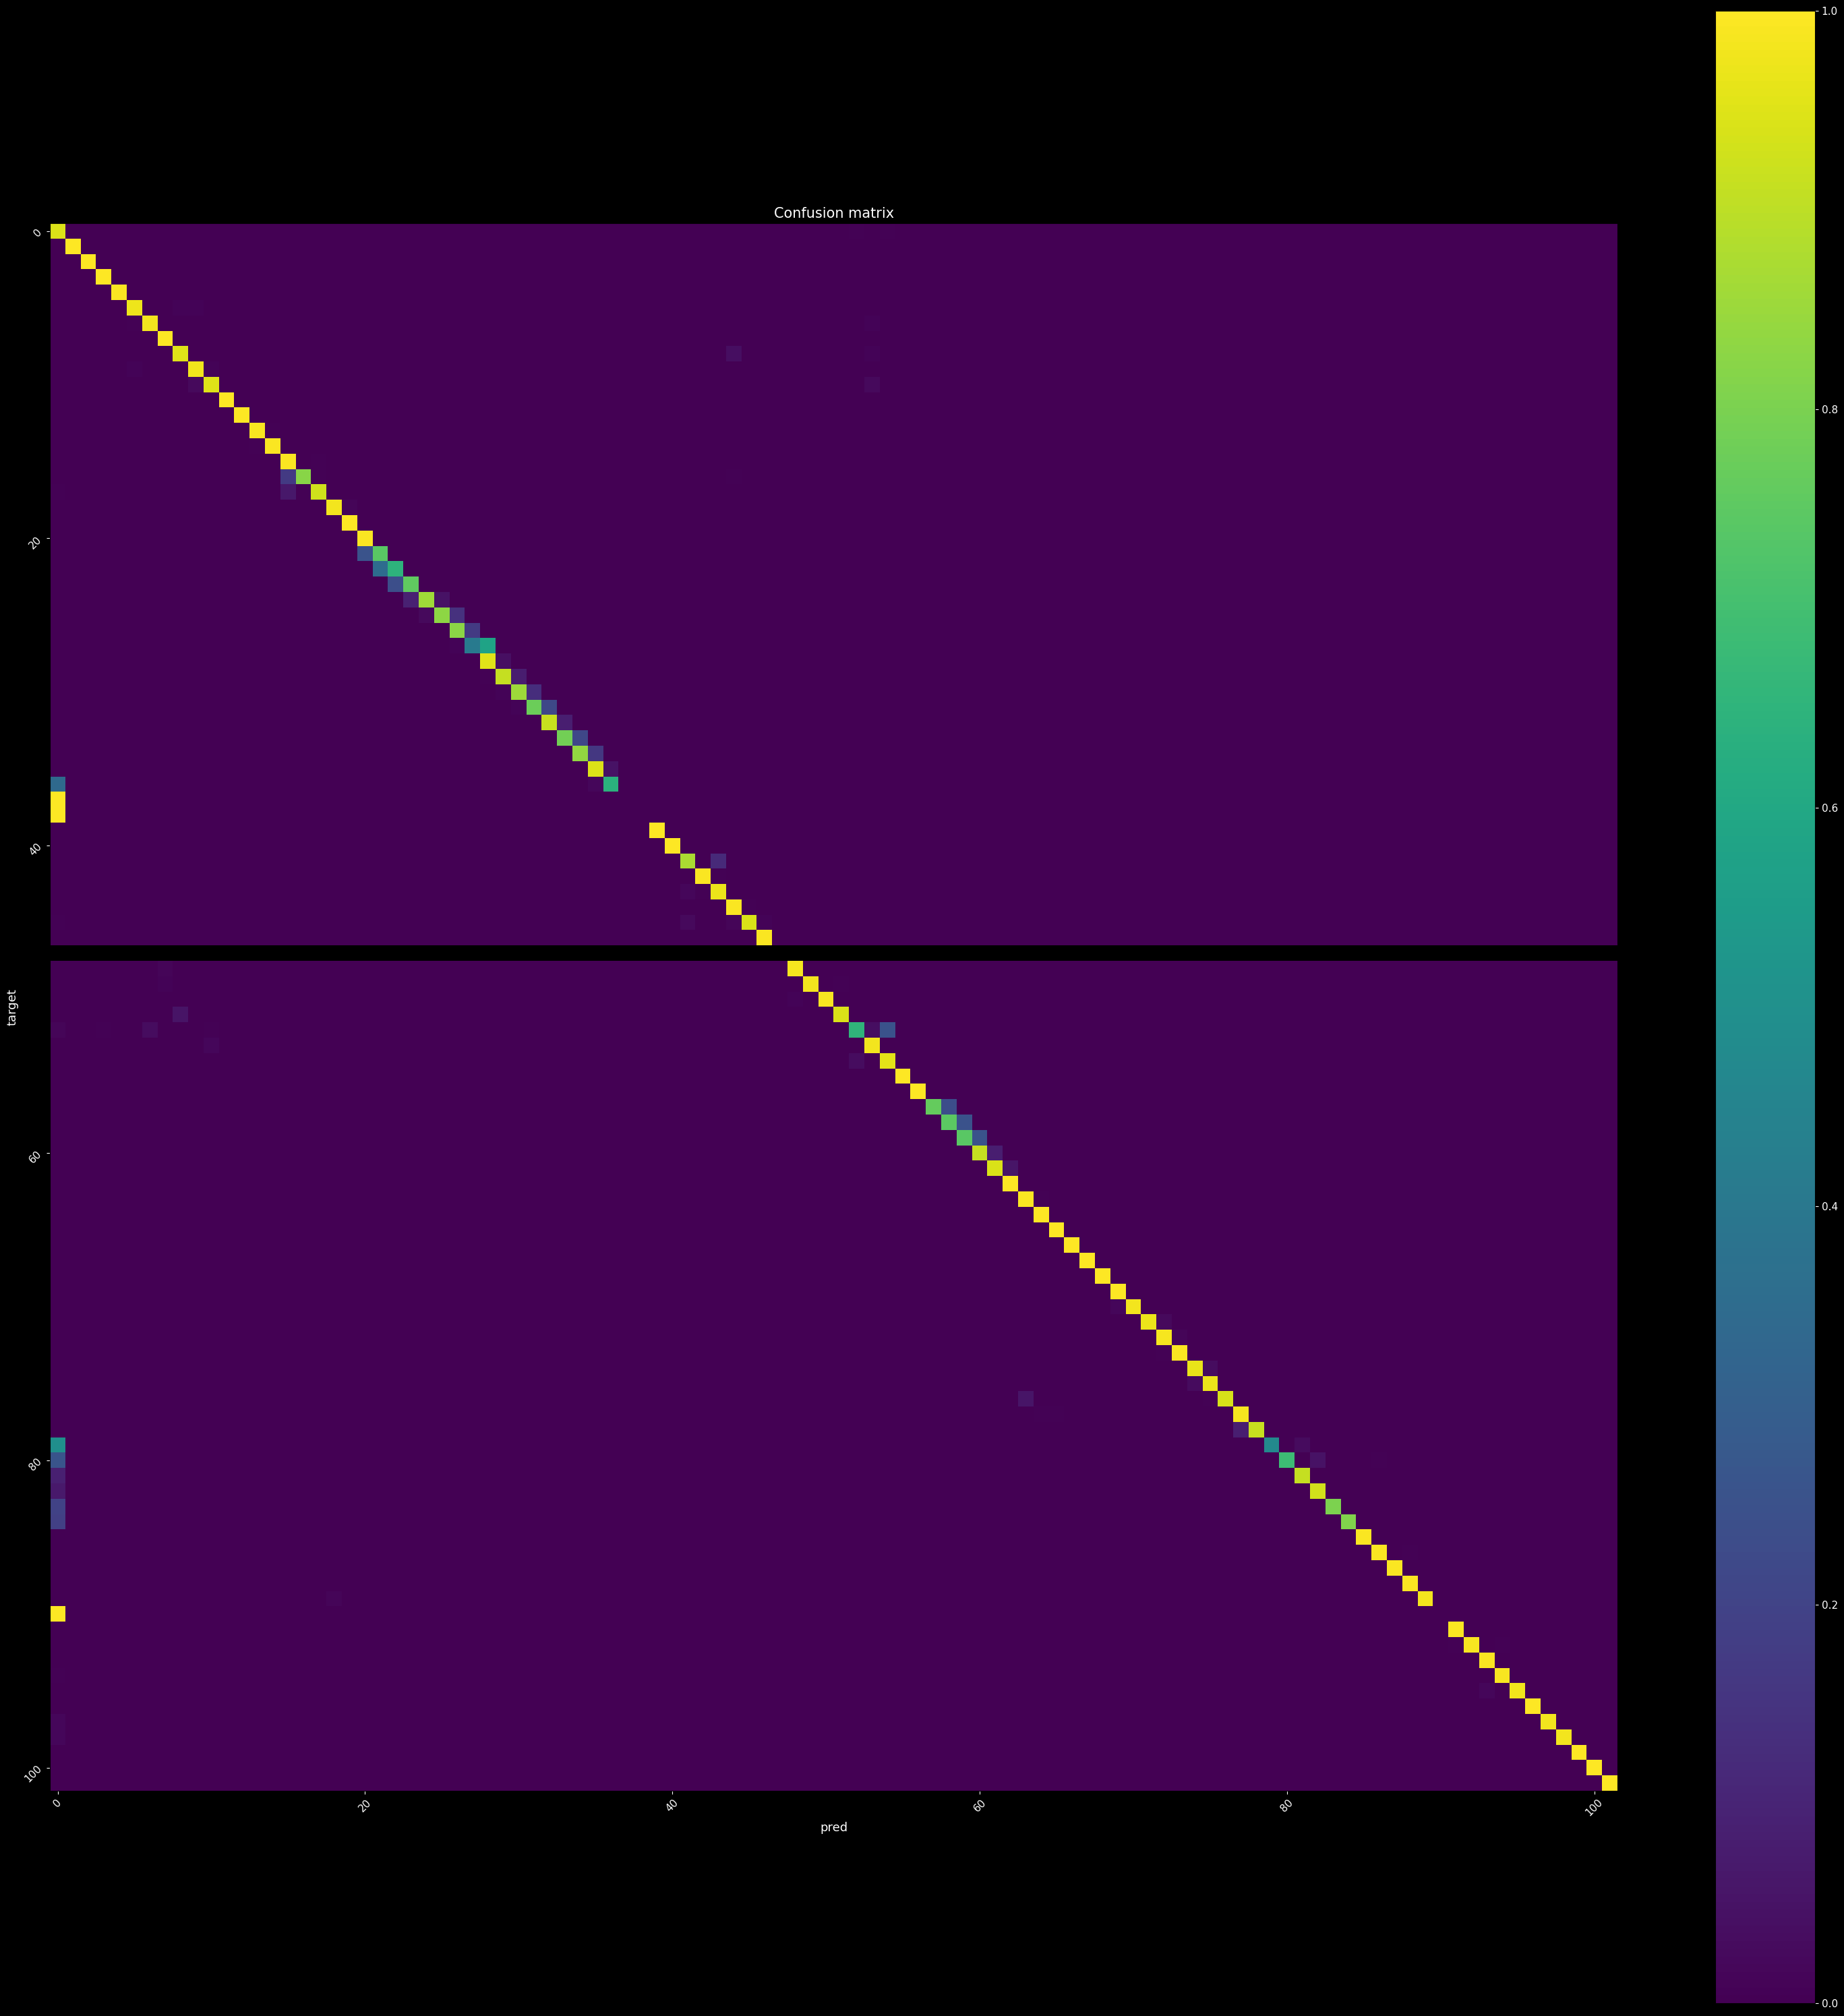

In [4]:
from sklearn.metrics import *

def evaluate(row, display = False):
    image  = model.get_input(row, get_frames = False)
    target = model.get_output(row, get_frames = False)

    pred   = model.infer(image, win_len = 64, hop_len = 32)
    
    print('Image shape : {} - Mask shape : {} - Output shape : {}'.format(image.shape, target.shape, pred.shape))
    
    with tf.device('cpu'):
        labels = tf.sparse.to_dense(target)
        labels = tf.argmax(labels, axis = -1).numpy()

    cm = multilabel_confusion_matrix(labels.reshape([-1]), pred.reshape([-1]))
    tn, fn, tp, fp = cm[:, 0, 0], cm[:, 1, 0], cm[:, 1, 1], cm[:, 0, 1]

    dices = 2 * tp / (2 * tp + fp + fn)
    #dices = dices[np.unique(labels)]

    print(np.mean(dices))
    print(np.mean(dices[dices > 0]))
    print("# wrong labels : {}".format(fp[dices == 0]))

    if display:
        plot(np.arange(len(dices)), dices, plot_type = 'bar', xlabel = 'pred label', ylabel = 'dice score', title = 'Reparition of dices')
        confusion = confusion_matrix(labels.reshape(-1), pred.reshape(-1))
        plot_matrix(confusion / np.sum(confusion, axis = -1, keepdims = True), title = 'Confusion matrix', xlabel = 'pred', ylabel = 'target')
    
    return labels, pred, dices

model.max_image_size = None
model.max_frames = -1

for idx, row in valid.sample(5, random_state = 0).iterrows():
    print('Row at index {}'.format(idx))
    labels, pred, dices = evaluate(row, display = True)

In [54]:
cm = multilabel_confusion_matrix(labels.reshape([-1]), pred.reshape([-1]))
tn, fn, tp, fp = cm[:, 0, 0], cm[:, 1, 0], cm[:, 1, 1], cm[:, 0, 1]

print(np.sum(np.logical_and(tp == 0, fn == 0)))
print(np.sum(dices == 0))
print(fp.shape, dices.shape)


1
1
(98,) (98,)


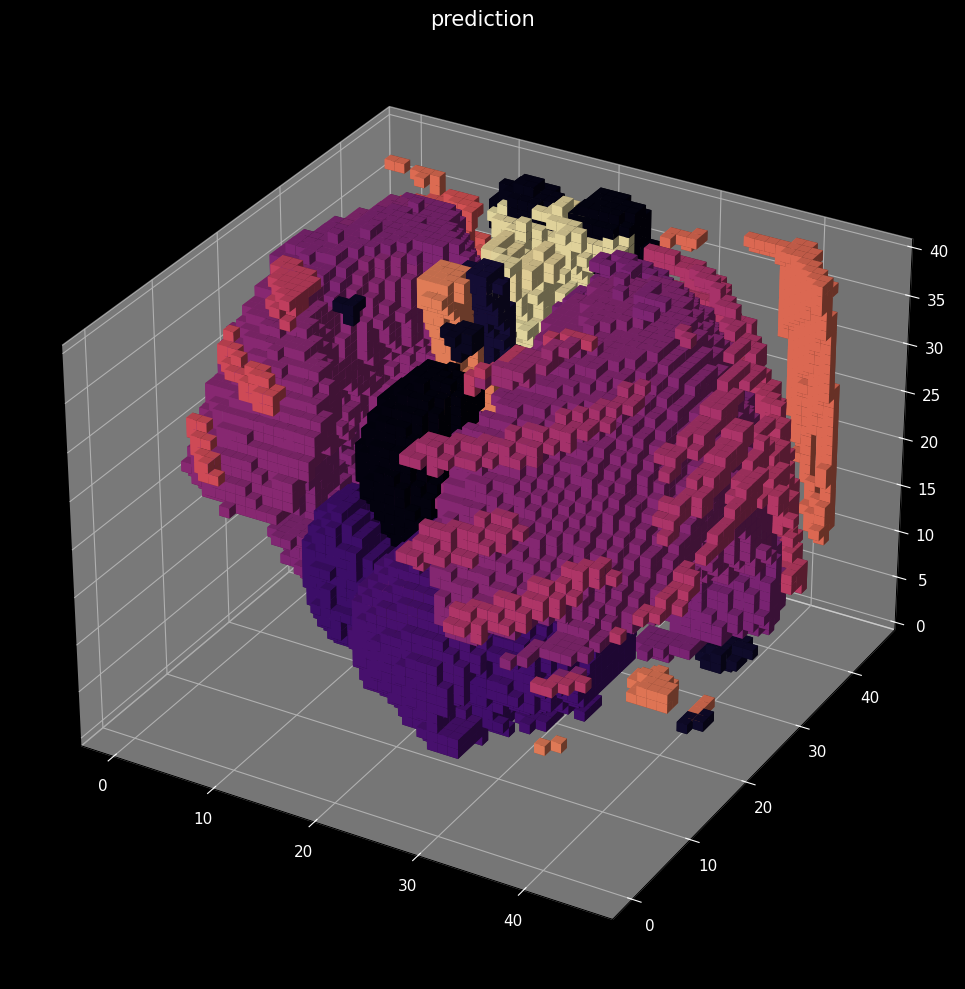

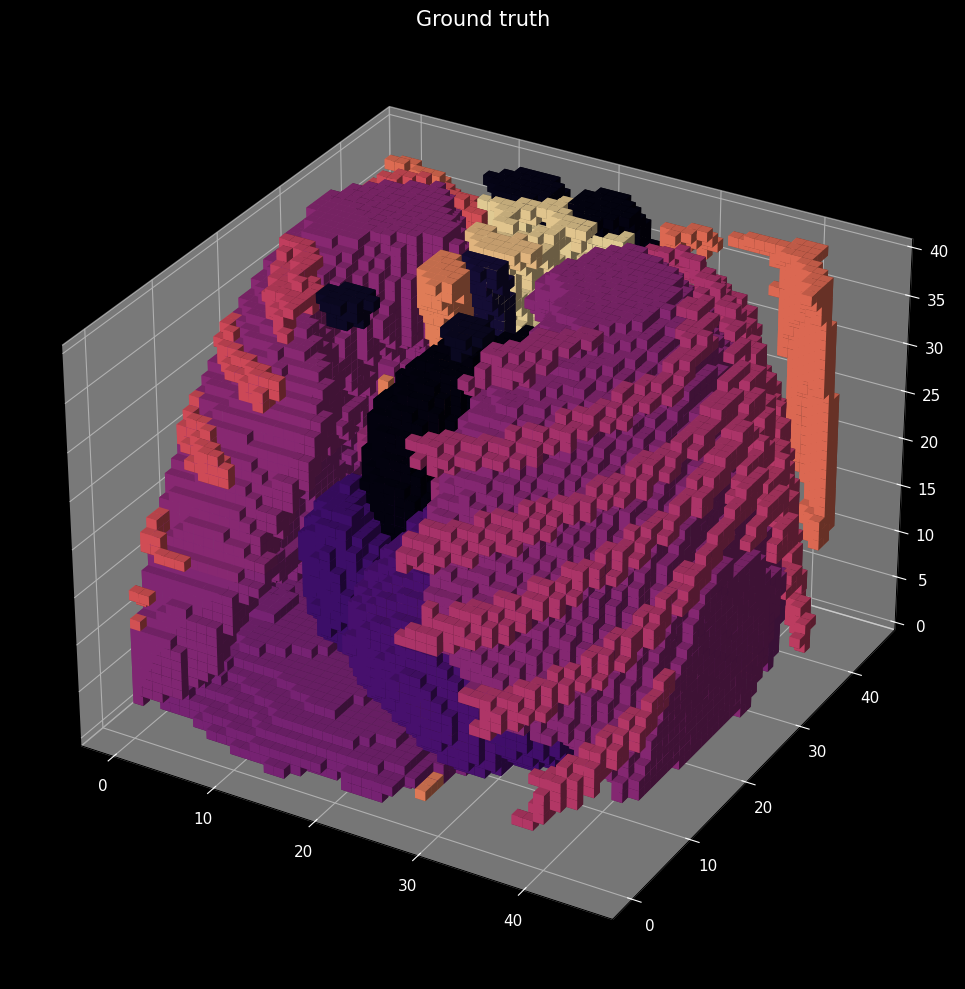

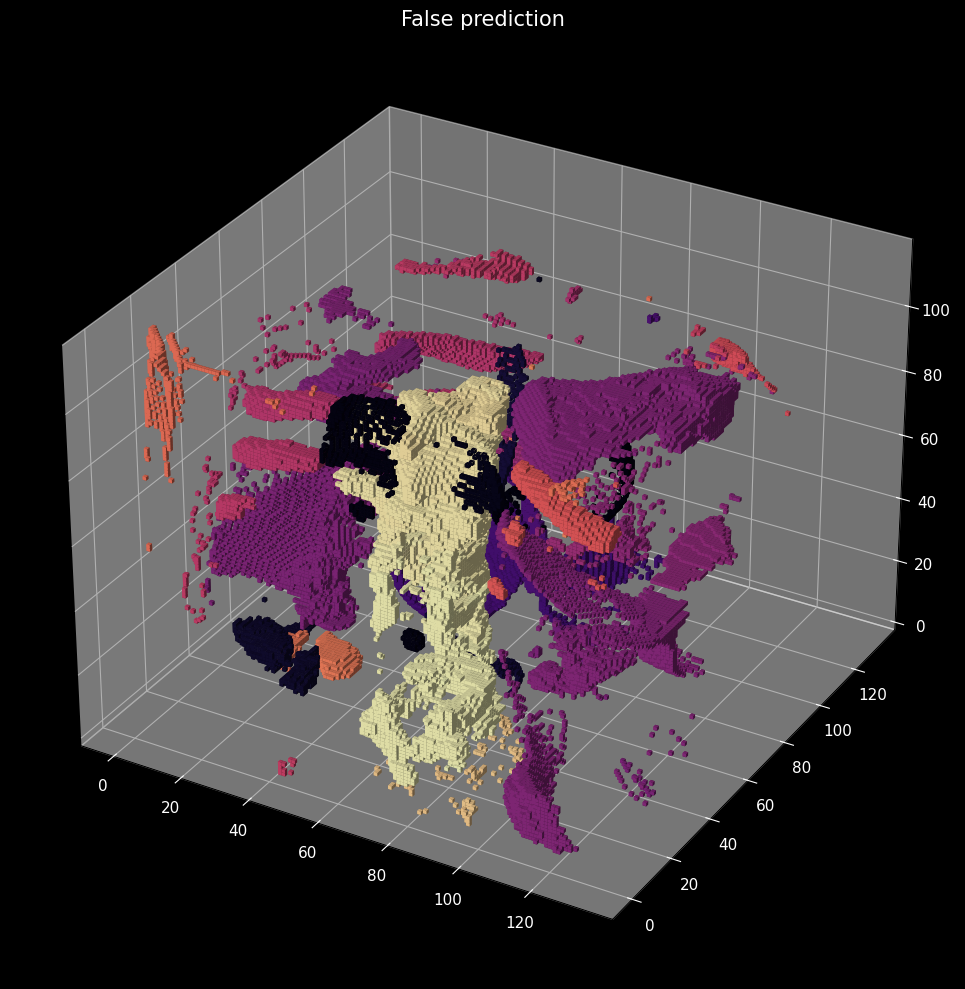

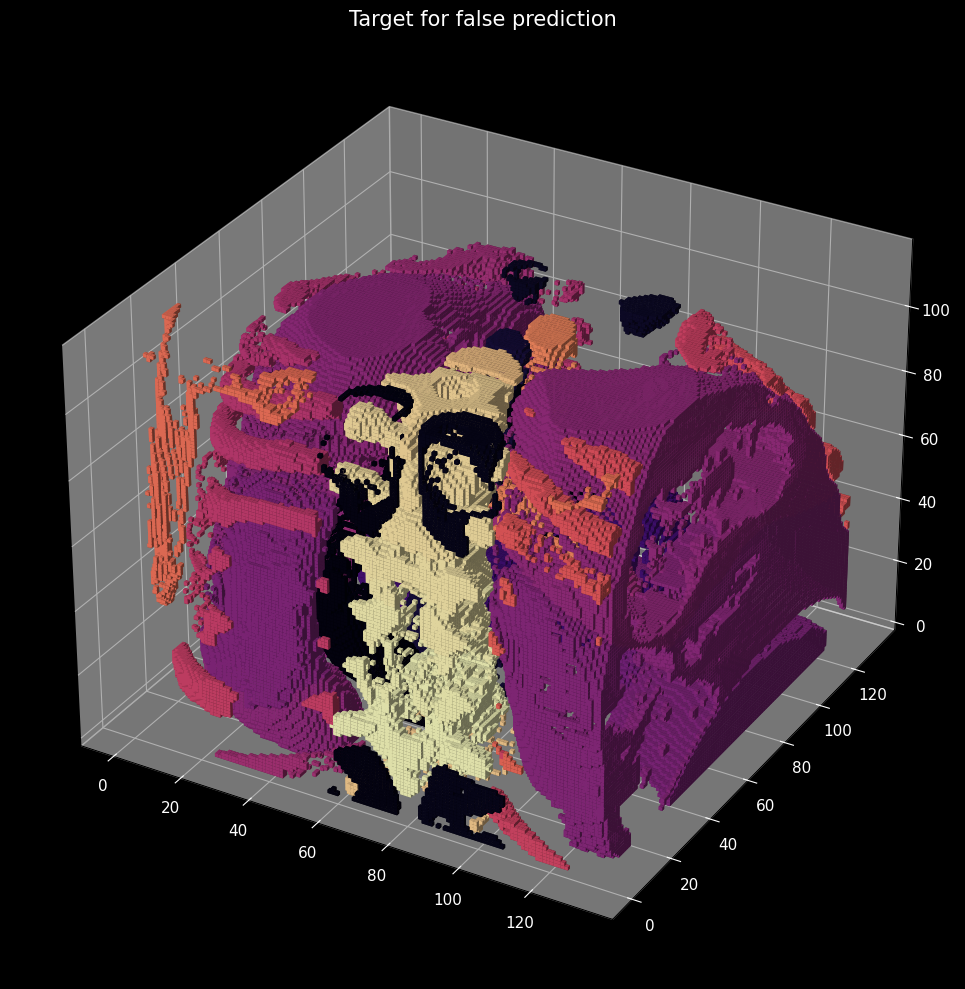

In [38]:
intersect = np.squeeze(pred == labels, axis = 0)

"""plot_multiple(
    target     = labels[0],
    prediction = pred[0],
    pred_error = {'volume' : pred[0] * np.logical_not(intersect), 'strides' : (1, 1, 1)},
    true_error = {'volume' : labels[0] * np.logical_not(intersect), 'strides' : (1, 1, 1)},

    ncols      = 2,
    strides    = (-3, -3, 3),
    plot_3d    = True,
    plot_type  = 'volume'
)
"""
plot_volume(pred[0], strides = (-3, -3, 3), title = 'prediction')
plot_volume(labels[0], strides = (-3, -3, 3), title = 'Ground truth')
plot_volume(pred[0] * np.logical_not(intersect), title = 'False prediction')
plot_volume(labels[0] * np.logical_not(intersect), title = 'Target for false prediction')

In [29]:
print(pred.shape)
print(labels.shape)

(1, 249, 188, 213)
(1, 249, 188, 213)


/tmp/ipykernel_639954/2613467823.py:4: RuntimeWarning: invalid value encountered in divide
  plot_matrix(confusion / np.sum(confusion, axis = -1, keepdims = True), title = 'Confusion matrix', xlabel = 'pred', ylabel = 'target')


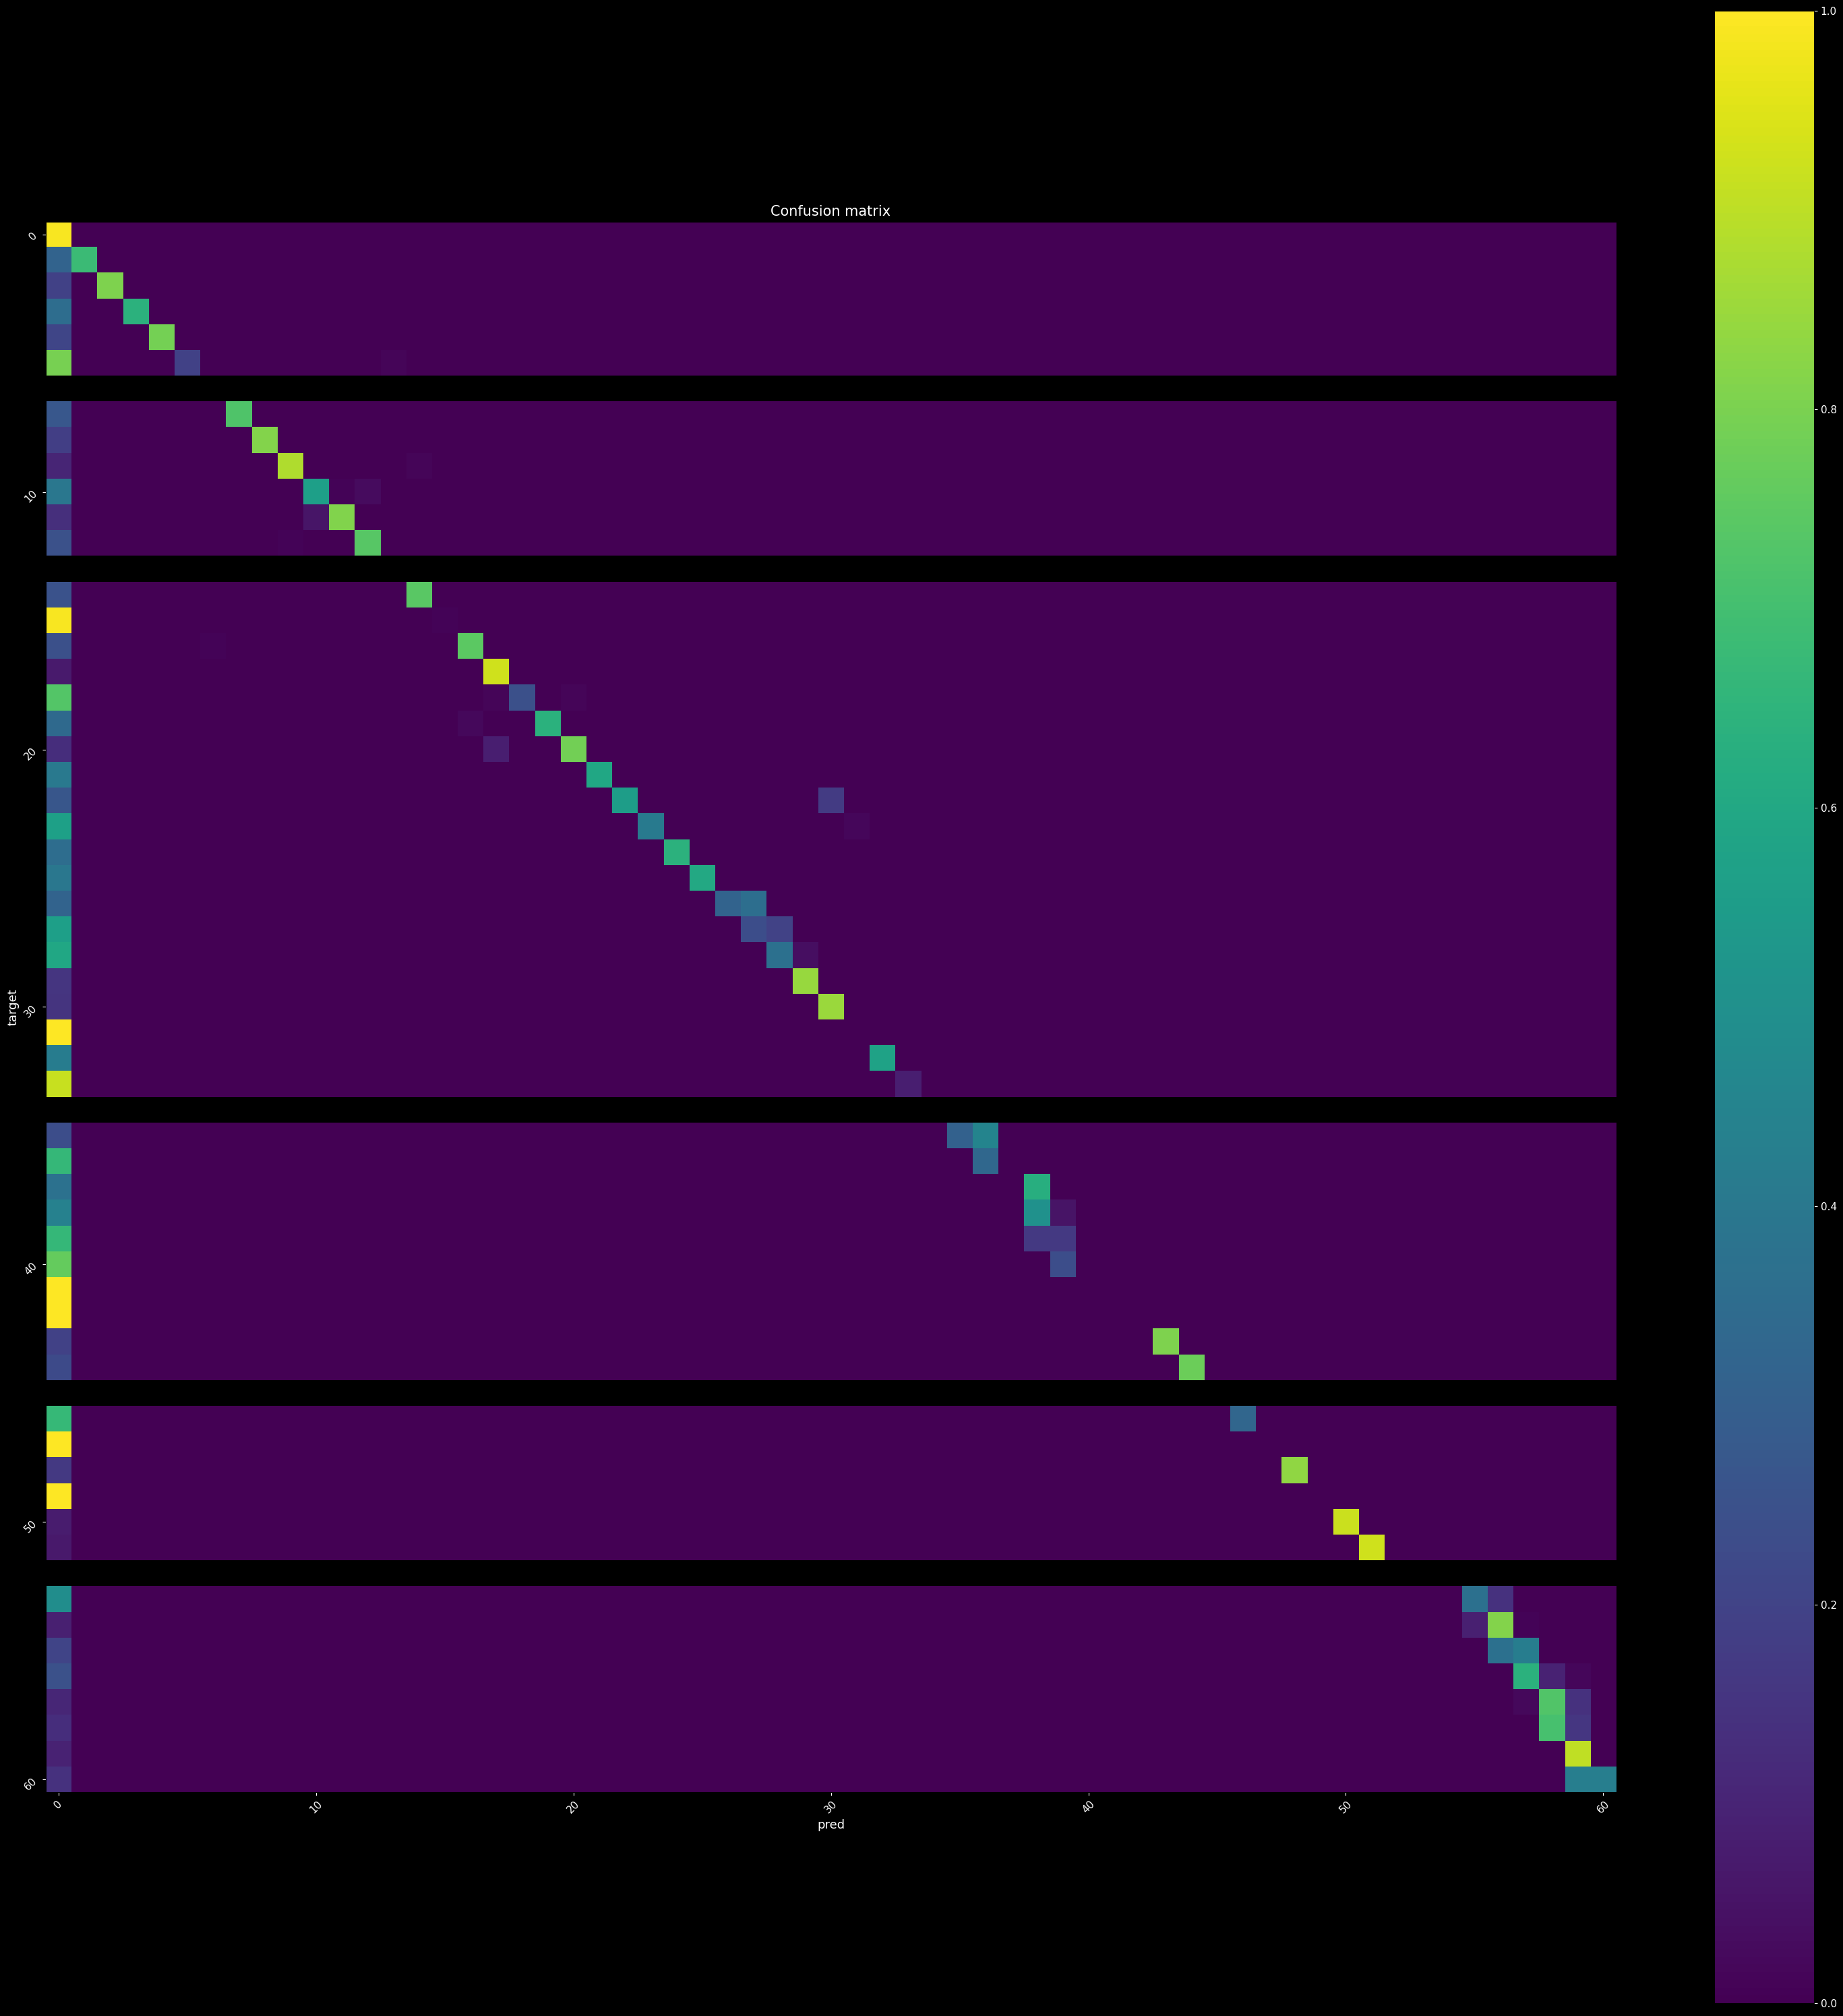

In [42]:
from utils import *

confusion = confusion_matrix(labels.reshape(-1), pred.reshape(-1))
plot_matrix(confusion / np.sum(confusion, axis = -1, keepdims = True), title = 'Confusion matrix', xlabel = 'pred', ylabel = 'target')

#plot_confusion_matrix(true = labels.reshape([-1]), pred = pred.reshape([-1]), norm = True)

## Prediction

In [9]:
from loggers import set_level, timer

time_logger = logging.getLogger('timer')

class Test:
    @staticmethod
    @timer
    def infer(self, data, win_len = -1, hop_len = -1, use_argmax = False, ** kwargs):
        def _remove_padding(output):
            return output[: data.shape[0], : data.shape[1], : data.shape[2]]
        
        unbatched_rank = 4 if self.is_3d else 3
        if len(data.shape) == unbatched_rank + 1: data = data[0]
        
        volume = self.preprocess_input(data)

        if not self.is_3d:
            return _remove_padding(self._infer_2d(
                volume, win_len = win_len, use_argmax = use_argmax, ** kwargs
            ))
        
        volume = tf.expand_dims(volume, axis = 0)
        
        if self.n_frames not in (-1, None): win_len = self.n_frames
        if win_len == -1: win_len = self.max_frames if self.max_frames not in (None, -1) else tf.shape(volume)[-2]
        if hop_len == -1: hop_len = win_len
        
        if win_len > 0 and win_len < volume.shape[-2]:
            infer_fn = self._infer_with_overlap if hop_len != win_len else self._infer_without_overlap
            
            pred = infer_fn(
                volume, win_len = win_len, hop_len = hop_len, use_argmax = use_argmax, ** kwargs
            )
        else:
            pred = self(volume, training = False)
            if use_argmax: pred = tf.argmax(pred, axis = -1)
        
        return _remove_padding(pred[0])

set_level('time')

model.max_image_size = None
model.max_frames     = -1

row    = dataset.loc[0]

image  = model.get_input(row, get_frames = False)
output = model.get_output(row, get_frames = False)

print('Image shape : {} - Mask shape : {}'.format(image.shape, output.shape))

pred = Test.infer(model, image, win_len = 64, hop_len = 32, use_argmax = True)

print('Prediction shape : {}'.format(pred.shape))

Image shape : (249, 188, 213, 1) - Mask shape : (249, 188, 213, 105)
Timers for logger timer :
- infer : 9.217 sec
  - prediction executed 5 times : 25 ms (5 ms / exec)
  - post-processing executed 5 times : 6.177 sec (1.235 sec / exec)
Prediction shape : (249, 188, 213)


In [6]:
inp = tf.expand_dims(model.preprocess_input(image), axis = 0)
for n in (32, 64, 96):
    %timeit model(inp[:, :, :, : n], training = False)

196 ms ± 232 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
The slowest run took 86.57 times longer than the fastest. This could mean that an intermediate result is being cached.
257 ms ± 168 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
The slowest run took 133.37 times longer than the fastest. This could mean that an intermediate result is being cached.
394 ms ± 256 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


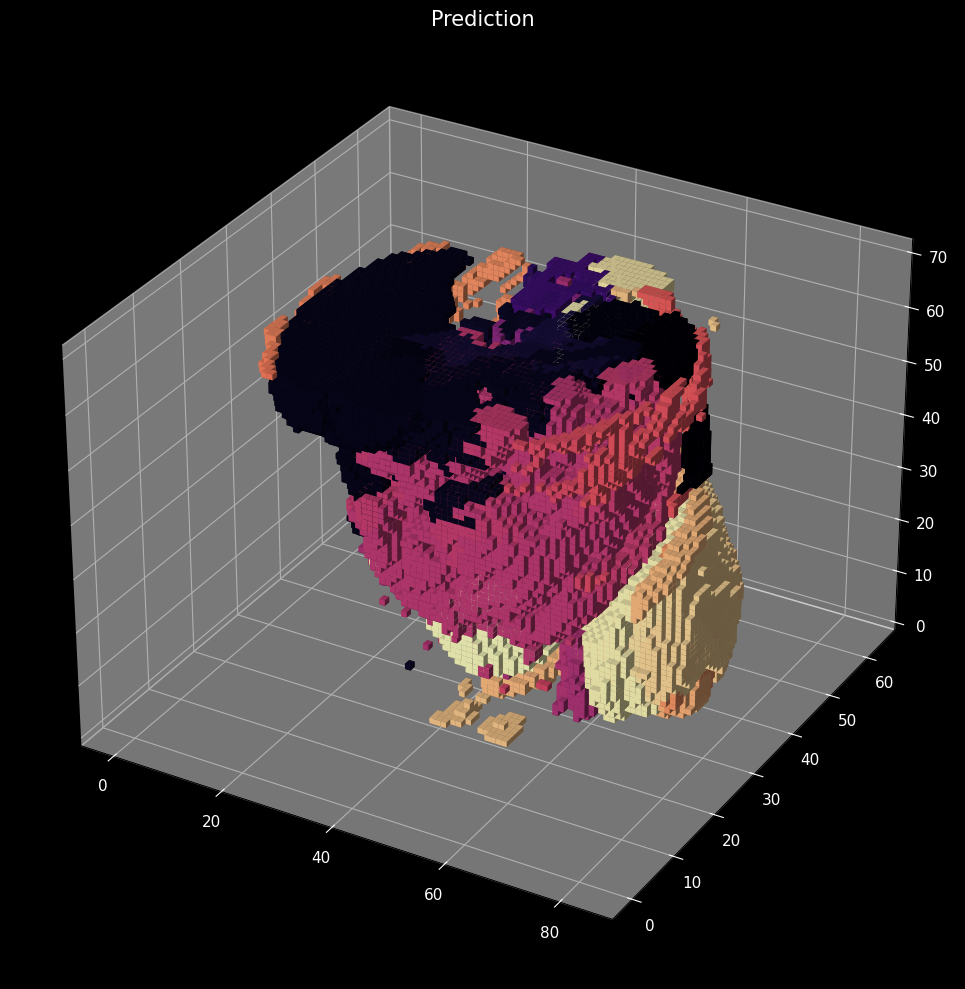

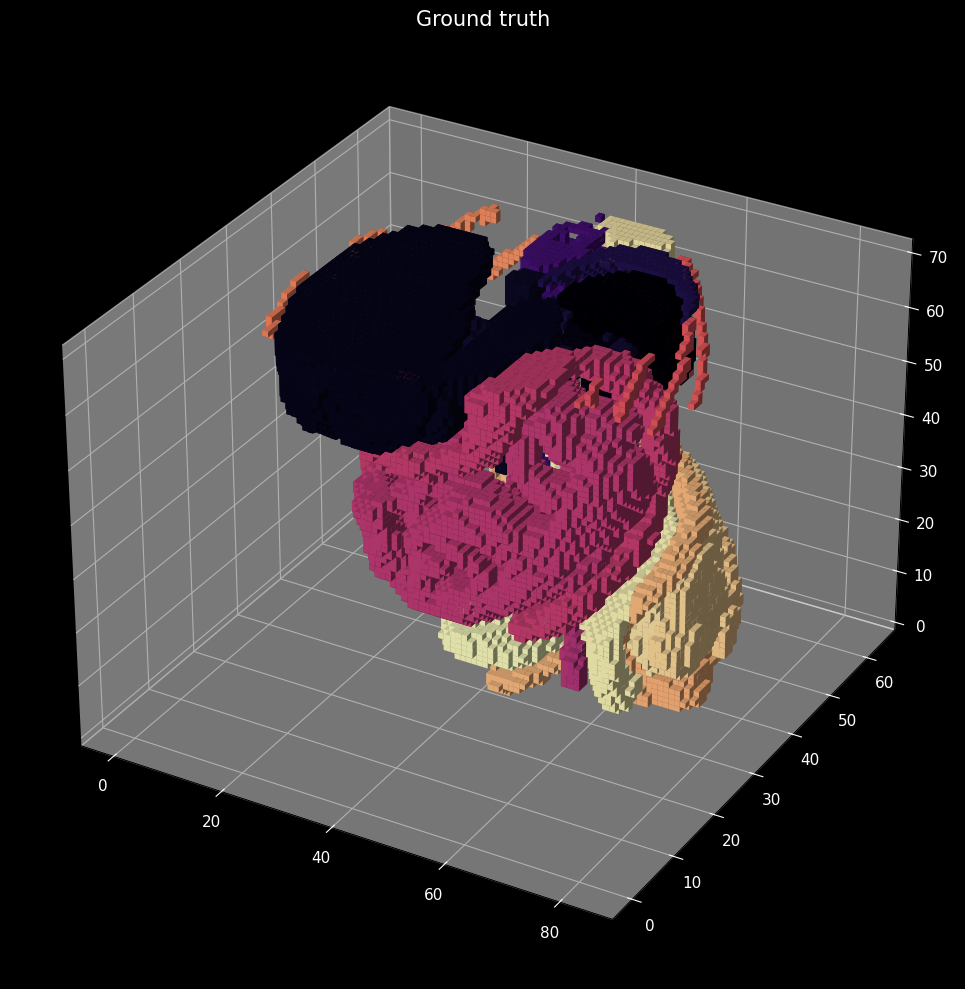

In [11]:
organs  = model.labels
indexes = [i for i, o in enumerate(organs) if (o) and ('rib' in o or 'vertebr' in o or 'right' not in o)]
strides = (-3, -3, 3)

plot_volume(
    pred, labels_to_show = indexes, strides = strides, title = 'Prediction',
    #filename = 'test_prediction.png', show = True
)
plot_volume(
    output, labels_to_show = indexes, strides = strides, title = 'Ground truth',
    #filename = 'test_target.png', show = True
)

## Tests

### Test dataset performances

In [4]:
from loggers import set_level

model.max_frames     = 32
model.max_image_size = None

set_level('debug', 'datasets')

config = model.get_dataset_config(is_validation = True, batch_size = 1, cache = False, prefetch = True, shuffle_size = 0)

ds_train = prepare_dataset(sklearn_shuffle(train, random_state = 1), ** config)

set_level('info', 'datasets')

test_dataset_time(ds_train, steps = 50)

Original dataset : <TensorSliceDataset element_spec={'subject_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'thickness': TensorSpec(shape=(), dtype=tf.int32, name=None), 'images': TensorSpec(shape=(), dtype=tf.string, name=None), 'segmentation': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(104,), dtype=tf.string, name=None), 'start_frame': TensorSpec(shape=(), dtype=tf.int32, name=None), 'end_frame': TensorSpec(shape=(), dtype=tf.int32, name=None), 'id': TensorSpec(shape=(), dtype=tf.string, name=None)}>
- Dataset after encoding : <ParallelMapDataset element_spec=(TensorSpec(shape=(None, None, None, None), dtype=tf.float32, name=None), SparseTensorSpec(TensorShape([None, None, None, None]), tf.uint8))>
- Dataset after filtering : <FilterDataset element_spec=(TensorSpec(shape=(None, None, None, None), dtype=tf.float32, name=None), SparseTensorSpec(TensorShape([None, None, None, None]), tf.uint8))>
- Dataset after mapping : <ParallelMapDataset ele

49it [00:20,  2.41it/s]


50 batchs in 20.370 sec sec (2.455 batch / sec)



TypeError: unsupported format string passed to SparseTensor.__format__

In [4]:
from loggers import set_level

model.max_frames     = 32
model.max_image_size = None

set_level('debug', 'datasets')

config = model.get_dataset_config(is_validation = True, batch_size = 1, cache = False, prefetch = True, shuffle_size = 0)

ds_train = prepare_dataset(train, ** config)

set_level('info', 'datasets')

test_dataset_time(ds_train, steps = 250)

Original dataset : <TensorSliceDataset element_spec={'subject_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'thickness': TensorSpec(shape=(), dtype=tf.int32, name=None), 'images': TensorSpec(shape=(), dtype=tf.string, name=None), 'segmentation': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(104,), dtype=tf.string, name=None), 'start_frame': TensorSpec(shape=(), dtype=tf.int32, name=None), 'end_frame': TensorSpec(shape=(), dtype=tf.int32, name=None), 'id': TensorSpec(shape=(), dtype=tf.string, name=None)}>
- Dataset after encoding : <ParallelMapDataset element_spec=(TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None), SparseTensorSpec(TensorShape([None, None, None, None]), tf.uint8))>
- Dataset after filtering : <FilterDataset element_spec=(TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None), SparseTensorSpec(TensorShape([None, None, None, None]), tf.uint8))>
- Dataset after mapping : <ParallelMapDataset element_s

249it [01:15,  3.29it/s]


250 batchs in 1min 15sec sec (3.305 batch / sec)



TypeError: unsupported format string passed to SparseTensor.__format__

In [4]:
for _, row in tqdm(train.iloc[2000:2500].iterrows()):
    inp, out = model.encode_data(row)
    inp, out = model.preprocess_data(inp, out)

500it [08:47,  1.05s/it]


In [5]:
for idx, row in tqdm(valid.sample(5).iterrows(), total = len(valid)):
    inp, out = model.encode_data(row)
    if model.filter_data(inp, out):
        image, _ = load_medical_image(row['images'])
        print(image.shape, inp.shape, out.dense_shape)
        inp, out = model.preprocess_data(inp, out)
        print(inp.shape, out.shape)
    else:
        print(inp.shape, out.indices.shape)

  0%|                                                                                | 1/2066 [00:02<1:29:41,  2.61s/it]

(281, 281, 453) (281, 281, 32, 1) tf.Tensor([281 281  32 105], shape=(4,), dtype=int64)
(288, 288, 32, 1) (288, 288, 32, 105)


  0%|                                                                                  | 2/2066 [00:03<48:27,  1.41s/it]

(135, 135, 249) (135, 135, 32, 1) tf.Tensor([135 135  32 105], shape=(4,), dtype=int64)
(144, 144, 32, 1) (144, 144, 32, 105)


  0%|                                                                                  | 3/2066 [00:03<37:19,  1.09s/it]

(193, 193, 252) (193, 193, 32, 1) tf.Tensor([193 193  32 105], shape=(4,), dtype=int64)
(208, 208, 32, 1) (208, 208, 32, 105)


  0%|▏                                                                                 | 4/2066 [00:04<32:50,  1.05it/s]

(199, 199, 239) (199, 199, 32, 1) tf.Tensor([199 199  32 105], shape=(4,), dtype=int64)
(208, 208, 32, 1) (208, 208, 32, 105)


  0%|▏                                                                                 | 5/2066 [00:07<51:33,  1.50s/it]

(299, 299, 443) (299, 299, 32, 1) tf.Tensor([299 299  32 105], shape=(4,), dtype=int64)
(304, 304, 32, 1) (304, 304, 32, 105)


In [6]:
%timeit load_medical_image(row['images'])
%timeit model.get_input(row, get_frames = False)
%timeit load_medical_seg(row['segmentation'])
%timeit model.get_output(row)


708 ms ± 27.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
870 ms ± 2.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
723 ms ± 464 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.23 s ± 8.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Dataset visualization

(192, 192) 32
Original dataset : <TensorSliceDataset element_spec={'subject_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'thickness': TensorSpec(shape=(), dtype=tf.int32, name=None), 'images': TensorSpec(shape=(), dtype=tf.string, name=None), 'segmentation': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(104,), dtype=tf.string, name=None), 'start_frame': TensorSpec(shape=(), dtype=tf.int32, name=None), 'end_frame': TensorSpec(shape=(), dtype=tf.int32, name=None), 'id': TensorSpec(shape=(), dtype=tf.string, name=None)}>
Tensor("ExpandDims:0", shape=(None, None, None, 1), dtype=float32) SparseTensor(indices=Tensor("cond_3/Identity:0", shape=(None, 4), dtype=int64), values=Tensor("cond_3/Identity_1:0", shape=(None,), dtype=float32), dense_shape=Tensor("cond_3/Identity_2:0", shape=(4,), dtype=int64))
- Dataset after encoding : <ParallelMapDataset element_spec=(TensorSpec(shape=(None, None, None, None), dtype=tf.float32, name=None), SparseTensorSpec(T

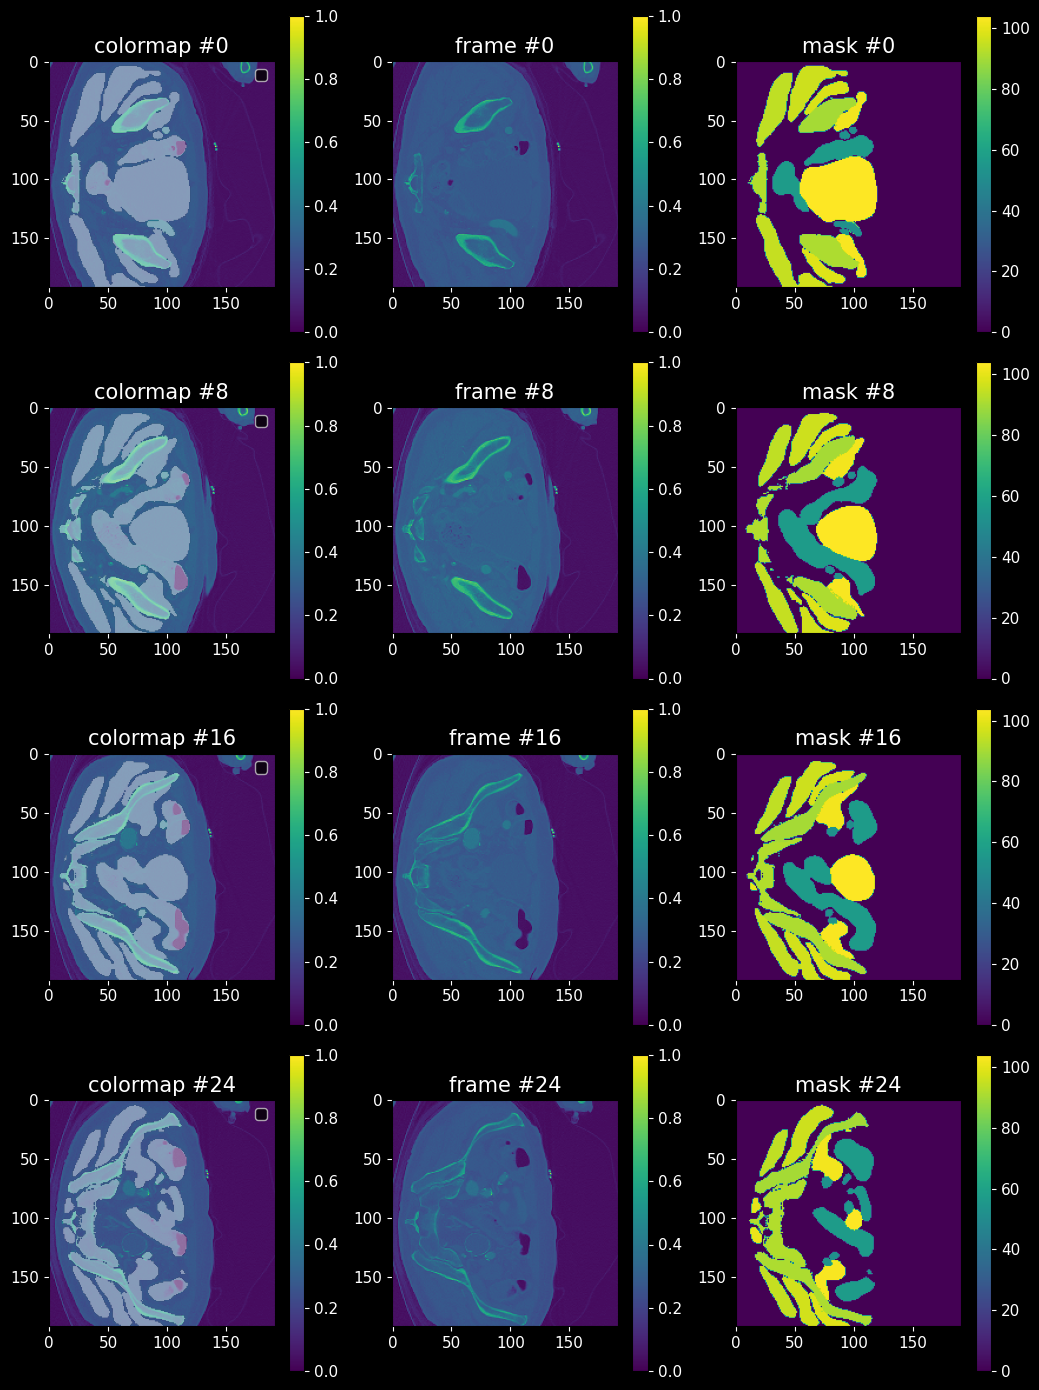

Input shape : (192, 192, 32, 1) - output shape : (192, 192, 32, 105)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


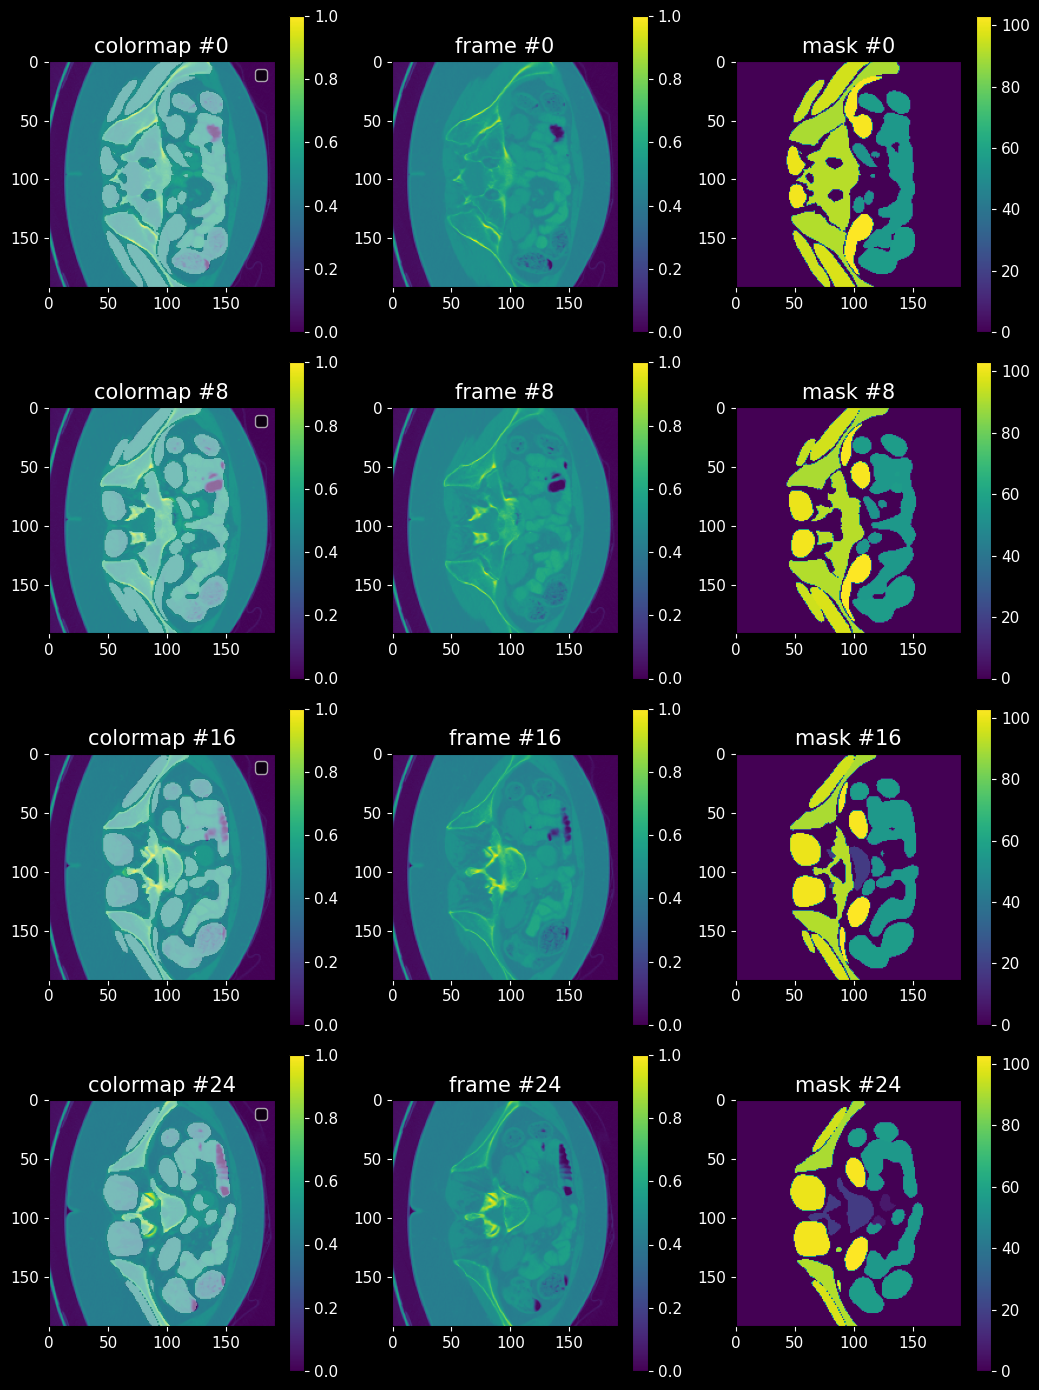

Input shape : (192, 192, 32, 1) - output shape : (192, 192, 32, 105)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


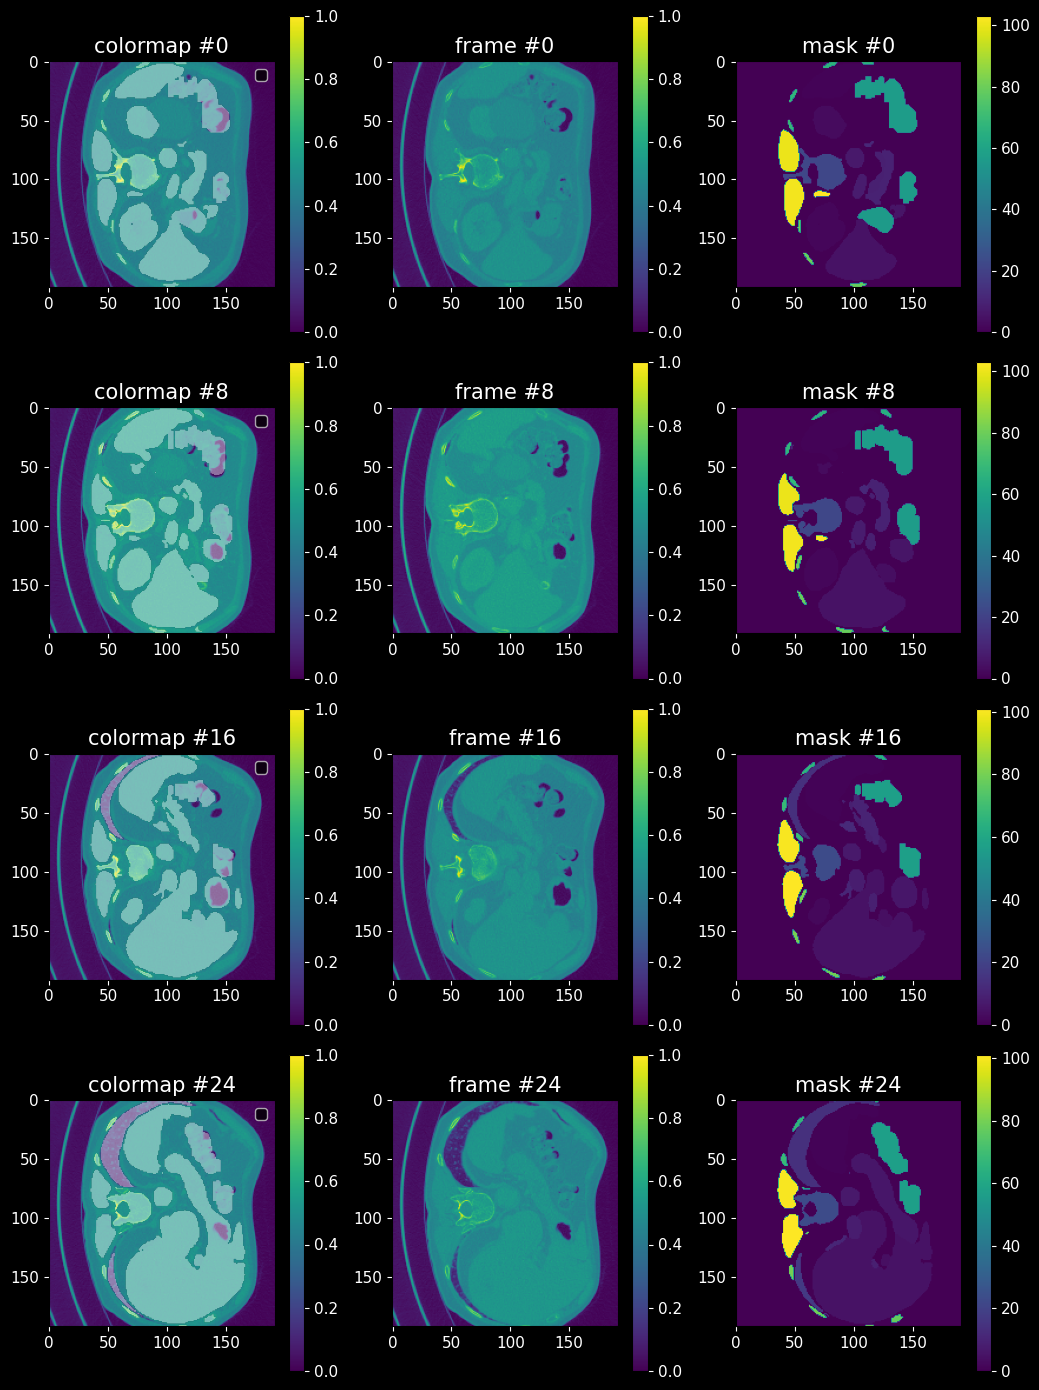

Input shape : (192, 176, 32, 1) - output shape : (192, 176, 32, 105)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


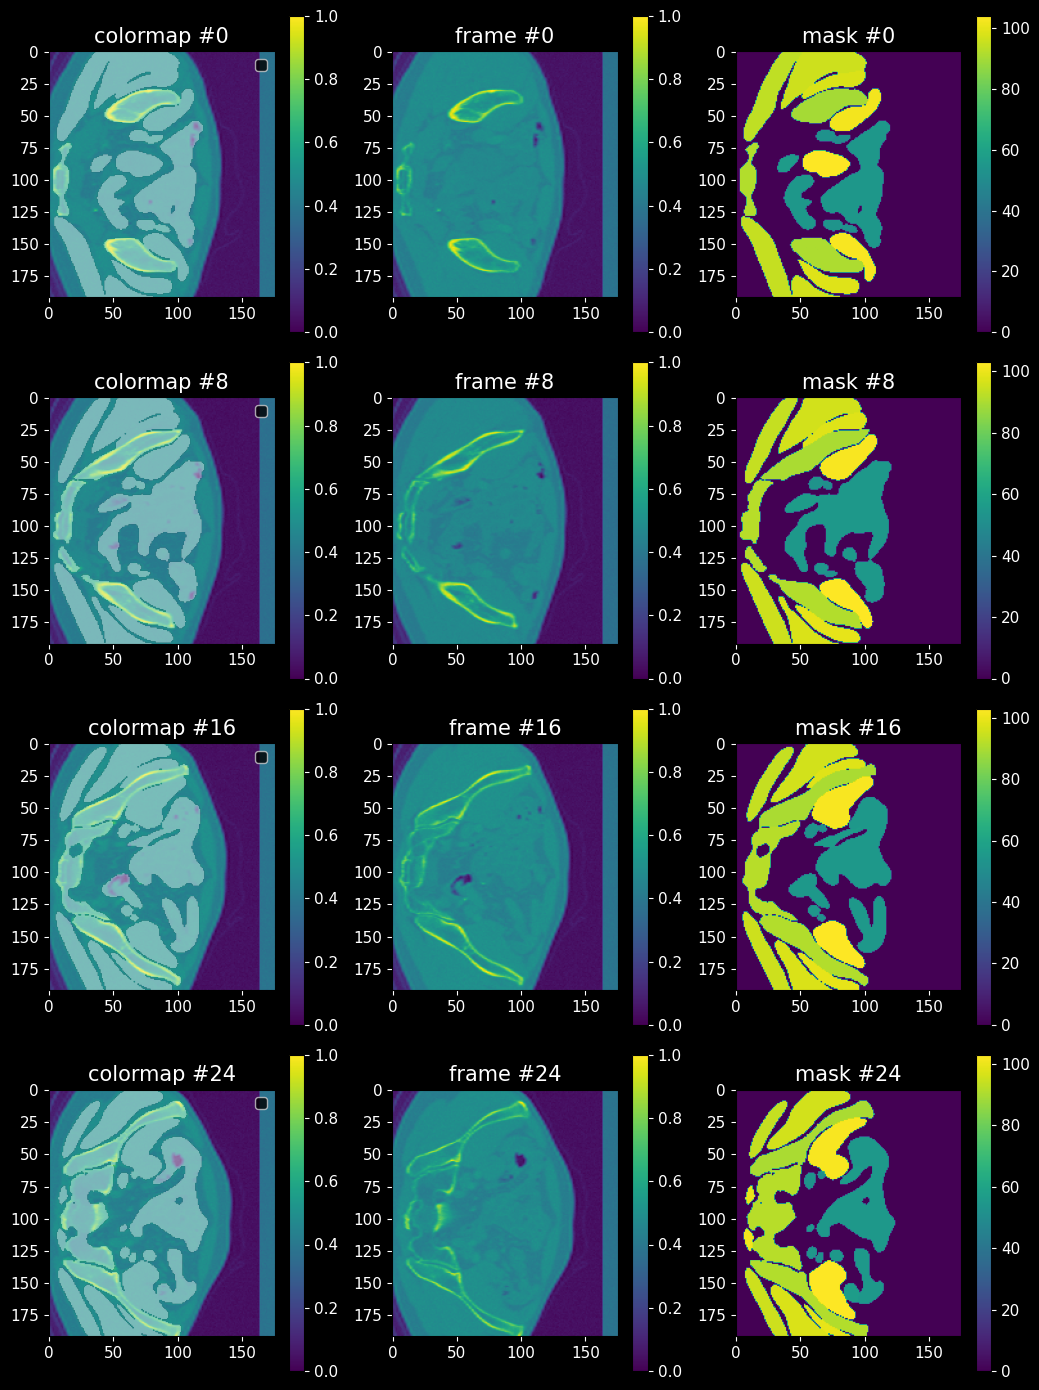

Input shape : (192, 192, 32, 1) - output shape : (192, 192, 32, 105)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


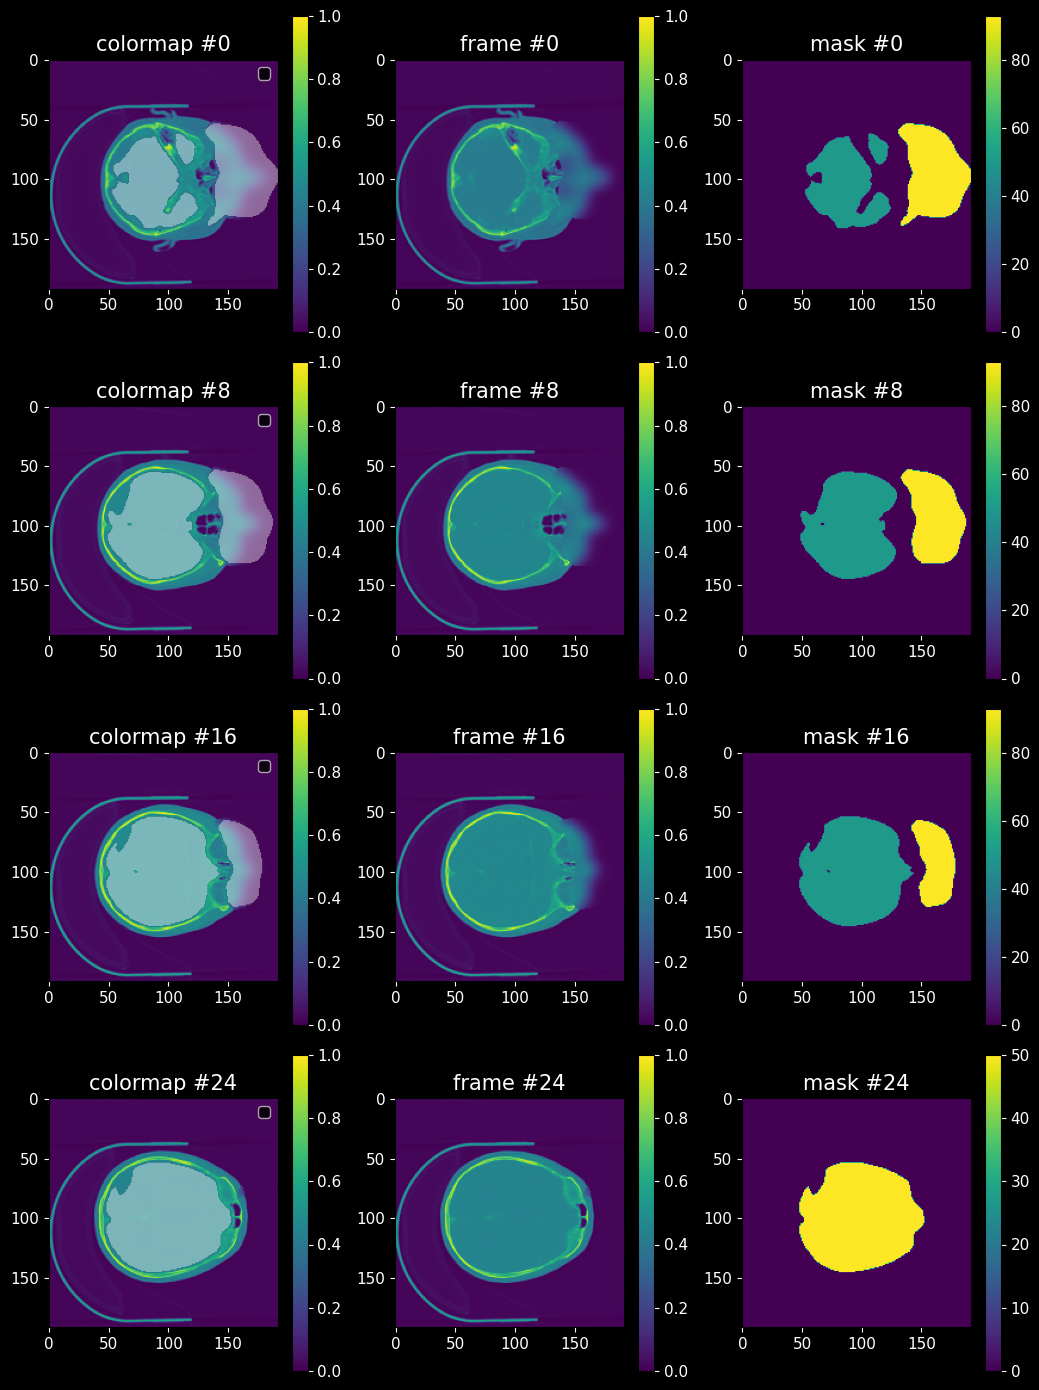

In [4]:
if 'highres' in model_name:
    max_size, max_frames = 512, 32
elif 'lowres' in model_name:
    max_size, max_frames = 128, 128
else:
    max_size, max_frames = 256 - 64, 32

model.max_frames     = max_frames
model.max_image_size = max_size
print(model.max_image_shape, model.max_frames)
config = model.get_dataset_config(is_validation = False, batch_size = 0, shuffle_size = 0)

set_level('debug', 'datasets')

ds = prepare_dataset(train.iloc[:5], ** config)

set_level('info', 'datasets')

for inp, out in ds:
    print('Input shape : {} - output shape : {}'.format(inp.shape, out.shape))
    plot_mask(inp[..., 0], out, n = 4)


### Test processing functions

In [4]:
n = 5
model.max_frames     = 32
model.max_image_size = None

for _, row in train.sample(n, random_state = 0).iterrows():
    tar_inp, _ = load_medical_data(row['images'], slice_start = row['start_frame'], slice_end = row['end_frame'])
    print(is_equal(tf.expand_dims(tar_inp, -1), model.get_input(row, normalize = False)[0])[1])

    inp, out = model.encode_data(row)
    print(is_equal(model.normalize_image(tf.expand_dims(tar_inp, -1)), inp)[1])

    tar_out, _ = load_medical_data(
        row['segmentation'],
        slice_start = row['start_frame'],
        slice_end   = row['end_frame'],
        
        labels  = row['label'],
        mapping = model._tf_mapping,
        
        use_sparse = True,
        is_one_hot = True,
        dtype      = tf.uint8
    )
    print(is_equal(tar_out.indices, out.indices)[1])


Value are equals !
Value are equals !
Value are equals !
Value are equals !
Value are equals !
Value are equals !
Value are equals !
Value are equals !
Value are equals !
Value are equals !
Value are equals !
Value are equals !
Value are equals !
Value are equals !
Value are equals !


### Configure `learning-rate scheduler`

This cell allows you to play with `learning_rate scheduler`'s parameters to get the one you want !

In [ ]:
lr = model.model_optimizer.learning_rate
lr.factor = 1024.
lr.warmup_steps = 1024
lr.plot(512 * 15)